In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:
import streamlit as st
import pandas as pd
import base64
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from PIL import Image

import warnings
warnings.filterwarnings('ignore')


from yahooquery import Ticker
from fbprophet import Prophet
import yfinance as yf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense,LSTM
#import stocker
 
import datetime as dt 
dia = dt.datetime.today().strftime(format='20%y-%m-%d')



import re
import urllib.request
import urllib.parse
import http.cookiejar
import time
import lxml

from lxml.html import fragment_fromstring
from collections import OrderedDict
import json
import ast
import datetime
import os
from pymongo import MongoClient

from datetime import datetime



# ------------------------------ SCRAPPING -------------------------------


def get_data(*args, **kwargs):
    url = 'http://www.fundamentus.com.br/resultado.php'
    cj = http.cookiejar.CookieJar()
    opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor(cj))
    opener.addheaders = [('User-agent', 'Mozilla/5.0 (Windows; U; Windows NT 6.1; rv:2.2) Gecko/20110201'),
                         ('Accept', 'text/html, text/plain, text/css, text/sgml, */*;q=0.01')]

    # Aqui estão os parâmetros de busca das ações
    # Estão em branco para que retorne todas as disponíveis
    data = {'pl_min':'','pl_max':'','pvp_min':'','pvp_max' :'','psr_min':'','psr_max':'','divy_min':'','divy_max':'',            'pativos_min':'','pativos_max':'','pcapgiro_min':'','pcapgiro_max':'','pebit_min':'','pebit_max':'', 'fgrah_min':'',
            'fgrah_max':'', 'firma_ebit_min':'', 'firma_ebit_max':'','margemebit_min':'','margemebit_max':'',            'margemliq_min':'','margemliq_max':'', 'liqcorr_min':'','liqcorr_max':'','roic_min':'','roic_max':'','roe_min':'',            'roe_max':'','liq_min':'','liq_max':'','patrim_min':'','patrim_max':'','divbruta_min':'','divbruta_max':'',         'tx_cresc_rec_min':'','tx_cresc_rec_max':'','setor':'','negociada':'ON','ordem':'1','x':'28','y':'16'}

    with opener.open(url, urllib.parse.urlencode(data).encode('UTF-8')) as link:
        content = link.read().decode('ISO-8859-1')

    pattern = re.compile('<table id="resultado".*</table>', re.DOTALL)
    reg = re.findall(pattern, content)[0]
    page = fragment_fromstring(reg)
    lista = OrderedDict()

    stocks = page.xpath('tbody')[0].findall("tr")

    todos = []
    for i in range(0, len(stocks)):
        lista[i] = {
            stocks[i].getchildren()[0][0].getchildren()[0].text: {
                'cotacao': stocks[i].getchildren()[1].text,
               'P/L': stocks[i].getchildren()[2].text,
               'P/VP': stocks[i].getchildren()[3].text,
               'PSR': stocks[i].getchildren()[4].text,
               'DY': stocks[i].getchildren()[5].text,
               'P/Ativo': stocks[i].getchildren()[6].text,
               'P/Cap.Giro': stocks[i].getchildren()[7].text,
               'P/EBIT': stocks[i].getchildren()[8].text,
               'P/Ativ.Circ.Liq.': stocks[i].getchildren()[9].text,
               'EV/EBIT': stocks[i].getchildren()[10].text,
               'EBITDA': stocks[i].getchildren()[11].text,
               'Mrg. Ebit': stocks[i].getchildren()[12].text,
               'Mrg.Liq.': stocks[i].getchildren()[13].text,
               'Liq.Corr.': stocks[i].getchildren()[14].text,
               'ROIC': stocks[i].getchildren()[15].text,
               'ROE': stocks[i].getchildren()[16].text,
               'Liq.2m.': stocks[i].getchildren()[17].text,
               'Pat.Liq': stocks[i].getchildren()[18].text,
               'Div.Brut/Pat.': stocks[i].getchildren()[19].text,
               'Cresc.5a': stocks[i].getchildren()[20].text
               }
            }

    return lista

def get_specific_data(stock):
    url = "http://www.fundamentus.com.br/detalhes.php?papel=" + stock
    cj = http.cookiejar.CookieJar()
    opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor(cj))
    opener.addheaders = [('User-agent', 'Mozilla/5.0 (Windows; U; Windows NT 6.1; rv:2.2) Gecko/20110201'),
                         ('Accept', 'text/html, text/plain, text/css, text/sgml, */*;q=0.01')]
    
    # Get data from site
    link = opener.open(url, urllib.parse.urlencode({}).encode('UTF-8'))
    content = link.read().decode('ISO-8859-1')

    # Get all table instances
    pattern = re.compile('<table class="w728">.*</table>', re.DOTALL)
    reg = re.findall(pattern, content)[0]
    reg = "<div>" + reg + "</div>"
    page = fragment_fromstring(reg)
    all_data = {}

    # There is 5 tables with tr, I will get all trs
    all_trs = []
    all_tables = page.xpath("table")

    for i in range(0, len(all_tables)):
        all_trs = all_trs + all_tables[i].findall("tr")

    # Run through all the trs and get the label and the
    # data for each line
    for tr_index in range(0, len(all_trs)):
        tr = all_trs[tr_index]
        # Get into td
        all_tds = tr.getchildren()
        for td_index in range(0, len(all_tds)):
            td = all_tds[td_index]

            label = ""
            data = ""

            # The page has tds with contents and some 
            # other with not
            if (td.get("class").find("label") != -1):
                # We have a label
                for span in td.getchildren():
                    if (span.get("class").find("txt") != -1):
                        label = span.text

                # If we did find a label we have to look 
                # for a value 
                if (label and len(label) > 0):
                    next_td = all_tds[td_index + 1]

                    if (next_td.get("class").find("data") != -1):
                        # We have a data
                        for span in next_td.getchildren():
                            if (span.get("class").find("txt") != -1):
                                if (span.text):
                                    data = span.text
                                else:
                                    # If it is a link
                                    span_children = span.getchildren()
                                    if (span_children and len(span_children) > 0):
                                        data = span_children[0].text

                                # Include into dict
                                all_data[label] = data

                                # Erase it
                                label = ""
                                data = ""

    return all_data


def flatten(d):
    '''
    Flatten an OrderedDict object
    '''
    result = OrderedDict()
    for k, v in d.items():
        if isinstance(v, dict):
            result.update(flatten(v))
        else:
            result[k] = v
    return result

# ----------------------------------SIDEBAR -------------------------------------------------------------
def main():

    st.sidebar.header("Explorador de ativos")
    n_sprites = st.sidebar.radio(
        "Escolha uma opção", options=["Análise técnica e fundamentalista", "Comparação de ativos","Descobrir novos ativos", "Rastreador de trade", "Análise de carteira e previsão de lucro"], index=0
    )

    st.sidebar.markdown('É preciso ter paciência e disciplina para se manter firme em suas convicções quando o mercado insiste que você está errado.!')
    st.sidebar.markdown('Benjamin Graham')
    st.sidebar.markdown('Email para contato: lucas.vasconcelos3@gmail.com')
    st.sidebar.markdown('Portfólio: https://github.com/lucasvascrocha')                                    

# ------------------------------ INÍCIO ANÁLISE TÉCNICA E FUNDAMENTALISTA ----------------------------             

    if n_sprites == "Análise técnica e fundamentalista":
        st.image('https://media.giphy.com/media/rM0wxzvwsv5g4/giphy.gif', width=400)    
        #image = Image.open('imagens/logo.jpg')
        #st.image(image, use_column_width=True)                       
        st.title('Análise Técnica e fundamentalista')
        st.subheader('Escolha o ativo que deseja analisar e pressione enter')
        nome_do_ativo = st.text_input('Nome do ativo')


        st.write('Este explorador funciona melhor para ações, porém também suporta alguns fundos imobiliários')    
        st.write('Os parâmetros utilizados em grande maioria foram seguindo as teorias de Benjamin Graham')

        if nome_do_ativo != "":
            nome_do_ativo = str(nome_do_ativo + '.SA')
            st.subheader('Analisando os dados')
            df = Ticker(nome_do_ativo,country='Brazil')
            time = df.history( period='max')
            st.dataframe(time.tail())

# ------------------------------ RESUMO ---------------------------- 

            resumo = pd.DataFrame(df.summary_detail)
            resumo = resumo.transpose()
            if len(nome_do_ativo) == 8:
              fundamentus = get_specific_data(nome_do_ativo[:5])
              fundamentus = pd.DataFrame([fundamentus])
              
              try:
                    
                  pfizer = yf.Ticker(nome_do_ativo)
                  info = pfizer.info 
                  st.title('PERFIL DA EMPRESA')
                  st.subheader(info['longName']) 
                  st.markdown('** Setor **: ' + info['sector'])
                  st.markdown('** Atividade **: ' + info['industry'])
                  st.markdown('** Website **: ' + info['website'])
              except:
                exit
                
              try:
                fundInfo = {
            'Dividend Yield (%) -12 meses': round(info['dividendYield']*100,2),
            'P/L': fundamentus['P/L'][0],
            'P/VP': fundamentus['P/VP'][0],
            'Próximo pagamento de dividendo:': (pfizer.calendar.transpose()['Earnings Date'].dt.strftime('%d/%m/%Y')[0])
        }   
                fundDF = pd.DataFrame.from_dict(fundInfo, orient='index')
                fundDF = fundDF.rename(columns={0: 'Valores'})
                st.subheader('Informações fundamentalistas') 
                st.table(fundDF)
              except:
                exit
              
            else:
              st.write('---------------------------------------------------------------------')
              st.dataframe(resumo) 
              pfizer = yf.Ticker(nome_do_ativo)
              info = pfizer.info 
              st.title('Company Profile')
              st.subheader(info['longName']) 
              try:
                st.markdown('** Sector **: ' + info['sector'])
                st.markdown('** Industry **: ' + info['industry'])
                st.markdown('** Website **: ' + info['website'])
              except:
                exit
            
# ------------------------------ GRÁFICOS DE RENDIMENTO ---------------------------- 

            if len(nome_do_ativo) == 8:
              
              import datetime
              fundamentalist = df.income_statement()
              fundamentalist['data'] = fundamentalist['asOfDate'].dt.strftime('%d/%m/%Y')
              fundamentalist = fundamentalist.drop_duplicates('asOfDate')
              fundamentalist = fundamentalist.loc[fundamentalist['periodType'] == '12M']

              #volatilidade
              TRADING_DAYS = 360
              returns = np.log(time['close']/time['close'].shift(1))
              returns.fillna(0, inplace=True)
              volatility = returns.rolling(window=TRADING_DAYS).std()*np.sqrt(TRADING_DAYS)
              vol = pd.DataFrame(volatility.iloc[-360:]).reset_index()

              #sharpe ratio
              sharpe_ratio = returns.mean()/volatility
              sharpe = pd.DataFrame(sharpe_ratio.iloc[-360:]).reset_index()

              div = time.reset_index()
              div['year'] = pd.to_datetime(div['date']).dt.strftime('%Y')
              div_group = div.groupby('year').agg({'close':'mean','dividends':'sum'})
              div_group['dividendo(%)'] = round((div_group['dividends'] * 100 ) / div_group['close'],4)

              from plotly.subplots import make_subplots
              fig = make_subplots(
                  rows=3, cols=2,
                  specs=[[{"type": "bar"}, {"type": "bar"}],
                        [{"type": "bar"}, {"type": "bar"}],
                        [{"type": "scatter"}, {"type": "scatter"}]],
                    subplot_titles=("Receita Total","Lucro",'Dividendos (%)','Dividendos unitário R$','Volatilidade', 'Sharpe ratio (Retorno/ Risco)')
              )

              fig.add_trace(go.Bar(x =pfizer.financials.transpose().index,  y=pfizer.financials.transpose()['Total Revenue']), row=1, col=1)

              fig.add_trace(go.Bar(x =pfizer.financials.transpose().index,  y=pfizer.financials.transpose()['Net Income From Continuing Ops']), row=1, col=2)

              fig.add_trace(go.Bar(x =div_group.reset_index().tail(5)['year'],  y=div_group.reset_index().tail(5)['dividendo(%)']),row=2, col=1)

              fig.add_trace(go.Bar(x =div_group.reset_index().tail(5)['year'],  y=div_group.reset_index().tail(5)['dividends']),row=2, col=2)

              fig.add_trace(go.Scatter(x =vol['date'],  y=vol['close']),row=3, col=1)

              fig.add_trace(go.Scatter(x =sharpe['date'],  y=sharpe['close']),row=3, col=2)

              fig.update_layout(height=800, showlegend=False)

              st.plotly_chart(fig)

            else:
                #volatilidade
              TRADING_DAYS = 160
              returns = np.log(time['close']/time['close'].shift(1))
              returns.fillna(0, inplace=True)
              volatility = returns.rolling(window=TRADING_DAYS).std()*np.sqrt(TRADING_DAYS)
              vol = pd.DataFrame(volatility.iloc[-160:]).reset_index()

              #sharpe ratio
              sharpe_ratio = returns.mean()/volatility
              sharpe = pd.DataFrame(sharpe_ratio.iloc[-160:]).reset_index()

              from plotly.subplots import make_subplots
              fig = make_subplots(
                  rows=1, cols=2,
                  specs=[[{"type": "scatter"}, {"type": "scatter"}]],
                    subplot_titles=('Volatilidade', 'Sharpe ratio (Retorno/ Risco)')
              )

              fig.add_trace(go.Scatter(x =vol['date'],  y=vol['close']),row=1, col=1)

              fig.add_trace(go.Scatter(x =sharpe['date'],  y=sharpe['close']),row=1, col=2)

              fig.update_layout(height=800, showlegend=False)

              st.plotly_chart(fig)

# ------------------------------ GRÁFICOS DE Candlestick---------------------------- 
            
            fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('OHLC', 'Volume'), 
               row_width=[0.2, 0.7])

            # Plot OHLC on 1st row
            fig.add_trace(go.Candlestick(x=time.reset_index()['date'][-90:],
                            open=time['open'][-90:], high=time['high'][-90:],
                            low=time['low'][-90:], close=time['close'][-90:], name="OHLC"), 
                            row=1, col=1)            

            # Bar trace for volumes on 2nd row without legend
            fig.add_trace(go.Bar(x=time.reset_index()['date'][-90:], y=time['volume'][-90:], showlegend=False), row=2, col=1)

            # Do not show OHLC's rangeslider plot 
            fig.update(layout_xaxis_rangeslider_visible=False)
            fig.update_layout(autosize=False,width=800,height=800,)
            st.plotly_chart(fig)
            
# ------------------------------ GRÁFICOS DE Retorno acumulado---------------------------- 

            layout = go.Layout(title="Retorno acumulado",xaxis=dict(title="Data"), yaxis=dict(title="Retorno"))
            fig = go.Figure(layout = layout)
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-365:], y=time.reset_index()['close'][-365:].pct_change().cumsum(), mode='lines', line_width=3,line_color='rgb(0,0,0)'))
            fig.update_layout(autosize=False,width=800,height=800,)

            st.plotly_chart(fig)

# ------------------------------ GRÁFICOS DE Médias móveis---------------------------- 

            rolling_50  = time['close'].rolling(window=50)
            rolling_mean_50 = rolling_50.mean()

            rolling_20  = time['close'].rolling(window=20)
            rolling_mean_20 = rolling_20.mean()

            rolling_10  = time['close'].rolling(window=10)
            rolling_mean_10 = rolling_10.mean()

            layout = go.Layout(title="Médias móveis",xaxis=dict(title="Data"), yaxis=dict(title="Preço R$"))
            fig = go.Figure(layout = layout)
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-120:], y=time["close"][-120:], mode='lines', line_width=3,name='Real',line_color='rgb(0,0,0)'))
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-120:], y=rolling_mean_50[-120:],mode='lines',name='MM(50)',opacity = 0.6))
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-120:], y=rolling_mean_20[-120:],mode='lines',name='MM(20)',opacity = 0.6))
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-120:], y=rolling_mean_10[-120:],mode='lines',name='MM(10)',opacity = 0.6,line_color='rgb(100,149,237)'))
            # fig.add_trace(go.Candlestick(x=time.reset_index()['date'][-120:], open=time['open'][-120:],high=time['high'][-120:],low=time['low'][-120:],close=time['close'][-120:]))
            fig.update_layout(autosize=False,width=800,height=800,)

            st.plotly_chart(fig)

# ------------------------------ GRÁFICOS DE Retração de Fibonacci---------------------------- 

            time_fibo = time.copy()
            periodo_fibonacci = int(st.number_input(label='periodo fibonacci',value=90))
            
            Price_Min =time_fibo[-periodo_fibonacci:]['low'].min()
            Price_Max =time_fibo[-periodo_fibonacci:]['high'].max()

            Diff = Price_Max-Price_Min
            level1 = Price_Max - 0.236 * Diff
            level2 = Price_Max - 0.382 * Diff
            level3 = Price_Max - 0.618 * Diff
         
            st.write ('0% >>' f'{round(Price_Max,2)}')
            st.write ('23,6% >>' f'{round(level1,2)}')
            st.write ('38,2% >>' f'{round(level2,2)}')
            st.write ('61,8% >>' f'{round(level3,2)}')
            st.write ('100% >>' f'{round(Price_Min,2)}')

            time_fibo['Price_Min'] = Price_Min
            time_fibo['level1'] = level1
            time_fibo['level2'] = level2
            time_fibo['level3'] = level3
            time_fibo['Price_Max'] = Price_Max

            layout = go.Layout(title=f'Retração de Fibonacci',xaxis=dict(title="Data"), yaxis=dict(title="Preço"))
            fig = go.Figure(layout = layout)
            fig.add_trace(go.Scatter(x=time_fibo[-periodo_fibonacci:].reset_index()['date'], y=time_fibo[-periodo_fibonacci:].close, mode='lines', line_width=3,name='Preço real',line_color='rgb(0,0,0)'))
            fig.add_trace(go.Scatter(x=time_fibo[-periodo_fibonacci:].reset_index()['date'], y=time_fibo[-periodo_fibonacci:].Price_Min, mode='lines', line_width=0.5,name='100%',line_color='rgb(255,0,0)',))
            fig.add_trace(go.Scatter(x=time_fibo[-periodo_fibonacci:].reset_index()['date'], y=time_fibo[-periodo_fibonacci:].level3, mode='lines', line_width=0.5,name='61,8%',line_color='rgb(255,255,0)',fill= 'tonexty', fillcolor ="rgba(255, 0, 0, 0.2)"))
            fig.add_trace(go.Scatter(x=time_fibo[-periodo_fibonacci:].reset_index()['date'], y=time_fibo[-periodo_fibonacci:].level2, mode='lines', line_width=0.5,name='38,2%',line_color='rgb(0,128,0)',fill= 'tonexty', fillcolor ="rgba(255, 255, 0, 0.2)"))
            fig.add_trace(go.Scatter(x=time_fibo[-periodo_fibonacci:].reset_index()['date'], y=time_fibo[-periodo_fibonacci:].level1, mode='lines', line_width=0.5,name='23,6%',line_color='rgb(128,128,128)',fill= 'tonexty', fillcolor ="rgba(0, 128, 0, 0.2)"))
            fig.add_trace(go.Scatter(x=time_fibo[-periodo_fibonacci:].reset_index()['date'], y=time_fibo[-periodo_fibonacci:].Price_Max, mode='lines', line_width=0.5,name='0%',line_color='rgb(0,0,255)',fill= 'tonexty', fillcolor ="rgba(128, 128, 128, 0.2)"))
            fig.update_layout(autosize=False,width=800,height=800,)

            st.plotly_chart(fig)

# ------------------------------ GRÁFICOS DE RSI---------------------------- 

            periodo_RSI = int(st.number_input(label='periodo RSI',value=90))

            delta = time['close'][-periodo_RSI:].diff()
            up, down = delta.copy(), delta.copy()

            up[up < 0] = 0
            down[down > 0] = 0

            period = 14
                
            rUp = up.ewm(com=period - 1,  adjust=False).mean()
            rDown = down.ewm(com=period - 1, adjust=False).mean().abs()

            time['RSI_' + str(period)] = 100 - 100 / (1 + rUp / rDown)
            time['RSI_' + str(period)].fillna(0, inplace=True)

            layout = go.Layout(title=f'RSI {periodo_RSI}',xaxis=dict(title="Data"), yaxis=dict(title="%RSI"))
            fig = go.Figure(layout = layout)
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-periodo_RSI:], y=round(time['RSI_14'][-periodo_RSI:],2), mode='lines', line_width=3,name=f'RSI {periodo_RSI}',line_color='rgb(0,0,0)'))

            fig.update_layout(autosize=False,width=800,height=800,)

            st.plotly_chart(fig)

# ------------------------------ GRÁFICOS DE pivôs---------------------------- 

            periodo_pivo = int(st.number_input(label='periodo pivô',value=20))

            time['PP'] = pd.Series((time['high'] + time['low'] + time['close']) /3)  
            time['R1'] = pd.Series(2 * time['PP'] - time['low'])  
            time['S1'] = pd.Series(2 * time['PP'] - time['high'])  
            time['R2'] = pd.Series(time['PP'] + time['high'] - time['low'])  
            time['S2'] = pd.Series(time['PP'] - time['high'] + time['low']) 

            layout = go.Layout(title=f'Pivô',xaxis=dict(title="Data"), yaxis=dict(title="Preço"))
            fig = go.Figure(layout = layout)
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-periodo_pivo:], y=round(time['close'][-periodo_pivo:],2), mode='lines', line_width=3,name=f'preço real',line_color='rgb(0,0,0)'))
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-periodo_pivo:], y=round(time['PP'][-periodo_pivo:],2), mode='lines', line_width=1,name=f'Ponto do pivô',line_color='rgb(0,128,0)'))
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-periodo_pivo:], y=round(time['R1'][-periodo_pivo:],2), mode='lines', line_width=1,name=f'Resistência 1',line_color='rgb(100,149,237)'))
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-periodo_pivo:], y=round(time['S1'][-periodo_pivo:],2), mode='lines', line_width=1,name=f'Suporte 1',line_color='rgb(100,149,237)'))
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-periodo_pivo:], y=round(time['R2'][-periodo_pivo:],2), mode='lines', line_width=1,name=f'Resistência 2',line_color='rgb(255,0,0)'))
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-periodo_pivo:], y=round(time['S2'][-periodo_pivo:],2), mode='lines', line_width=1,name=f'Suporte 2',line_color='rgb(255,0,0)'))
            fig.update_layout(autosize=False,width=800,height=800,)

            st.plotly_chart(fig)

# ------------------------------ GRÁFICOS DE Bolinger---------------------------- 

            periodo_bolinger = int(st.number_input(label='periodo Bolinger',value=180))

            time['MA20'] = time['close'].rolling(20).mean()
            time['20 Day STD'] = time['close'].rolling(window=20).std()
            time['Upper Band'] = time['MA20'] + (time['20 Day STD'] * 2)
            time['Lower Band'] = time['MA20'] - (time['20 Day STD'] * 2)

            layout = go.Layout(title=f'Banda de Bolinger',xaxis=dict(title="Data"), yaxis=dict(title="Preço"))
            fig = go.Figure(layout = layout)
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-periodo_bolinger:], y=round(time['Upper Band'][-periodo_bolinger:],2), mode='lines', line_width=1,name=f'Banda superior',line_color='rgb(255,0,0)'))
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-periodo_bolinger:], y=round(time['Lower Band'][-periodo_bolinger:],2), mode='lines', line_width=1,name=f'Banda inferior',line_color='rgb(255,0,0)',fill= 'tonexty', fillcolor ="rgba(255, 0, 0, 0.1)",opacity=0.2))
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-periodo_bolinger:], y=round(time['close'][-periodo_bolinger:],2), mode='lines', line_width=3,name=f'preço real',line_color='rgb(0,0,0)'))
            fig.add_trace(go.Scatter(x=time.reset_index()['date'][-periodo_bolinger:], y=round(time['MA20'][-periodo_bolinger:],2), mode='lines', line_width=2,name=f'MM 20',line_color='rgb(0,128,0)'))
            fig.update_layout(autosize=False,width=800,height=800,)

            st.plotly_chart(fig)

# ------------------------------ Previsões---------------------------- 

            st.subheader('Previsões')

            st.write('As previsões são feitas levando em conta apenas o movimento gráfico, porém o movimento do preço de um ativo é influenciado por diversos outros fatores, com isso, deve se considerar as previsões como uma hipótese de o preço do ativo variar somente pela sua variação gráfica')

            st.write('Previsão considerando os últimos 365 dias, pode ser entendida como uma tendência dos dados segundo o último ano')

            time = time.reset_index()
            time = time[['date','close']]
            time.columns = ['ds','y']

            #Modelling
            m = Prophet()
            m.fit(time[-360:])
            future = m.make_future_dataframe(periods=30)
            forecast = m.predict(future[-30:])

            from fbprophet.plot import plot_plotly, plot_components_plotly

            fig1 = plot_plotly(m, forecast)
            st.plotly_chart(fig1)
            #st.plotly_chart(m, forecast)
            fig2 = m.plot_components(forecast)
            st.plotly_chart(fig2)

            #st.write('Previsão considerando as últimas semanas, pode ser entendida como uma tendência dos dados segundo os últimos dias. Leva em consideração diversos fatores como: Índice de força relativa RSI, oscilador estocástico %K, Indicador Willian %R além do movimento gráfico dos últimos dias')

            #predict = stocker.predict.tomorrow(nome_do_ativo)

            #st.write('Previsão para o dia:',f'{predict[2]}','é que a ação feche no valor de: R$',f'{predict[0]}')

            #preço_ontem= round(time['y'][-1:].values[0],2)
            #if predict[0] < preço_ontem:
                #st.write('Previsão para o dia:',f'{predict[2]}','é que a ação caia de ',f'{preço_ontem}', 'para valor de: R$ ',f'{predict[0]}')
            #else:
                #st.write('Previsão para o dia:',f'{predict[2]}','é que a ação suba de ',f'{preço_ontem}', 'para valor de: R$ ',f'{predict[0]}')
                         
# ------------------------------ INÍCIO Comparação de ativos ------------------------------------------------------------------------------------

    if n_sprites == "Comparação de ativos":

        st.image('https://media.giphy.com/media/JtBZm3Getg3dqxK0zP/giphy.gif', width=300)    
        #image = Image.open('imagens/logo.jpg')
        #st.image(image, use_column_width=True)                       
        st.title('Comparação de ativos')
        st.subheader('Escolha até 4 ativos para comparar')
        nome_do_ativo1 = st.text_input('Nome do 1º ativo')
        nome_do_ativo2 = st.text_input('Nome do 2º ativo')
        nome_do_ativo3 = st.text_input('Nome do 3º ativo')
        nome_do_ativo4 = st.text_input('Nome do 4º ativo')
        
        if nome_do_ativo4 != "":
            st.subheader('Analisando os dados')
            nome_do_ativo1 = str(nome_do_ativo1 + '.SA')
            nome_do_ativo2 = str(nome_do_ativo2 + '.SA')
            nome_do_ativo3 = str(nome_do_ativo3 + '.SA')
            nome_do_ativo4 = str(nome_do_ativo4 + '.SA')
            
            df = Ticker([nome_do_ativo1,nome_do_ativo2,nome_do_ativo3,nome_do_ativo4],country='Brazil')
            time = df.history( start='2018-01-01', end = (dt.datetime.today() + dt.timedelta(days=1)).strftime(format='20%y-%m-%d'))
            lista = get_data()
            todos = pd.DataFrame(flatten(lista).keys()).transpose()
            todos.columns = todos.iloc[0]

            for i in range(len(lista)):
              todos = pd.concat([todos,pd.DataFrame(lista[i]).transpose()])

            todos = todos.iloc[1:]
            todos['P/L'] = todos['P/L'].str.replace('.','')
            todos['DY'] = todos['DY'].str.replace('%','')
            todos['Liq.2m.'] = todos['Liq.2m.'].str.replace('.','')
            todos['Pat.Liq'] = todos['Pat.Liq'].str.replace('.','')
            todos = todos.replace(',','.', regex=True)
            todos = todos.apply(pd.to_numeric,errors='ignore')

            comparar = todos.loc[todos.index.isin([nome_do_ativo1[:5],nome_do_ativo2[:5],nome_do_ativo3[:5],nome_do_ativo4[:5]])]
            
            st.dataframe(comparar)

# ------------------------------ INÍCIO Comparação DY ---------------
            
            layout = go.Layout(title="DY",xaxis=dict(title="Ativo"), yaxis=dict(title="DY %"))
            fig = go.Figure(layout = layout)
            fig.add_trace(go.Bar(x=comparar.sort_values('DY',ascending=True).index, y=comparar.sort_values('DY',ascending=True)['DY'] ))

            fig.update_layout(autosize=False,width=800,height=400,)

            st.plotly_chart(fig)

# ------------------------------ INÍCIO Comparação P/L ---------------

            layout = go.Layout(title="P/L",xaxis=dict(title="Ativo"), yaxis=dict(title="P/L"))
            fig = go.Figure(layout = layout)
            fig.add_trace(go.Bar(x=comparar.sort_values('P/L',ascending=True).index, y=comparar.sort_values('P/L',ascending=True)['P/L'] ))

            fig.update_layout(autosize=False,width=800,height=400,)

            st.plotly_chart(fig)

# ------------------------------ INÍCIO Comparação P/V---------------

            layout = go.Layout(title="P/VP",xaxis=dict(title="Ativo"), yaxis=dict(title="P/VP"))
            fig = go.Figure(layout = layout)
            fig.add_trace(go.Bar(x=comparar.sort_values('P/VP',ascending=True).index, y=comparar.sort_values('P/VP',ascending=True)['P/VP'] ))

            fig.update_layout(autosize=False,width=800,height=400,)

            st.plotly_chart(fig)

# ------------------------------ INÍCIO Comparação P/L * P/VP---------------

            layout = go.Layout(title="P/L X P/VP",xaxis=dict(title="Ativo"), yaxis=dict(title="P/L X P/VP"))
            fig = go.Figure(layout = layout)
            fig.add_trace(go.Bar(x=comparar.index, y=comparar['P/L'] * comparar['P/VP'] ))

            fig.update_layout(autosize=False,width=800,height=400,)

            st.plotly_chart(fig)

# ------------------------------ GRÁFICOS DE retorno acumulado---------------------------- 

            periodo_inicio = int(st.number_input(label='periodo retorno acumulado',value=360))

            ret = time.reset_index()
            layout = go.Layout(title="Retorno acumulado",xaxis=dict(title="Data"), yaxis=dict(title="Retorno"))
            fig = go.Figure(layout = layout)
            for i in range(len(ret['symbol'].unique())):
              fig.add_trace(go.Scatter(x=ret.loc[ret['symbol']==ret['symbol'].unique()[i]][-periodo_inicio:]['date'], y=ret.loc[ret['symbol']==ret['symbol'].unique()[i]][-periodo_inicio:]['close'].pct_change().cumsum(),mode='lines',name=ret.reset_index()['symbol'].unique()[i]))


            fig.update_layout(autosize=False,width=800,height=800,)

            st.plotly_chart(fig)

# ------------------------------ GRÁFICOS DE MÉDIAS MÓVEIS 50---------------------------- 

            rolling_50  = time['close'].rolling(window=50)
            rolling_mean_50 = rolling_50.mean()
            rolling_mean_50 = pd.DataFrame(rolling_mean_50.reset_index())
            # mm50 = time.reset_index()


            layout = go.Layout(title="MÉDIAS MÓVEIS 50",xaxis=dict(title="Data"), yaxis=dict(title="Preço R$"))
            fig = go.Figure(layout = layout)
            for i in range(len(rolling_mean_50['symbol'].unique())):
              fig.add_trace(go.Scatter(x=rolling_mean_50.loc[rolling_mean_50['symbol']==rolling_mean_50['symbol'].unique()[i]]['date'], y=rolling_mean_50.loc[rolling_mean_50['symbol']==rolling_mean_50['symbol'].unique()[i]]['close'],mode='lines',name=time.reset_index()['symbol'].unique()[i]))


            fig.update_layout(autosize=False,width=800,height=800,)

            st.plotly_chart(fig)

# ------------------------------ GRÁFICOS DE MÉDIAS MÓVEIS 20---------------------------- 

            rolling_50  = time['close'].rolling(window=20)
            rolling_mean_50 = rolling_50.mean()
            rolling_mean_50 = pd.DataFrame(rolling_mean_50.reset_index())
            # mm50 = time.reset_index()


            layout = go.Layout(title="MÉDIAS MÓVEIS 20",xaxis=dict(title="Data"), yaxis=dict(title="Preço R$"))
            fig = go.Figure(layout = layout)
            for i in range(len(rolling_mean_50['symbol'].unique())):
              fig.add_trace(go.Scatter(x=rolling_mean_50.loc[rolling_mean_50['symbol']==rolling_mean_50['symbol'].unique()[i]]['date'], y=rolling_mean_50.loc[rolling_mean_50['symbol']==rolling_mean_50['symbol'].unique()[i]]['close'],mode='lines',name=time.reset_index()['symbol'].unique()[i]))


            fig.update_layout(autosize=False,width=800,height=800,)

            st.plotly_chart(fig)

# ------------------------------ GRÁFICOS DE volatilidade--------------------------- 

            TRADING_DAYS = 360
            returns = np.log(time['close']/time['close'].shift(1))
            returns.fillna(0, inplace=True)
            volatility = returns.rolling(window=TRADING_DAYS).std()*np.sqrt(TRADING_DAYS)
            vol = pd.DataFrame(volatility).reset_index()
            vol = vol.dropna()

            layout = go.Layout(title=f"Volatilidade",xaxis=dict(title="Data"), yaxis=dict(title="Volatilidade"))
            fig = go.Figure(layout = layout)
            for i in range(len(vol['symbol'].unique())):
              fig.add_trace(go.Scatter(x=vol.loc[vol['symbol']==vol['symbol'].unique()[i]]['date'], y=vol.loc[vol['symbol']==vol['symbol'].unique()[i]]['close'],name=vol['symbol'].unique()[i] ))

            fig.update_layout(autosize=False,width=800,height=400,)

            st.plotly_chart(fig)

# ------------------------------ GRÁFICOS DE sharpe_ratio--------------------------- 

            sharpe_ratio = returns.mean()/volatility
            sharpe = pd.DataFrame(sharpe_ratio).reset_index()
            sharpe = sharpe.dropna()

            layout = go.Layout(title=f"SHARP (Risco / Volatilidade)",xaxis=dict(title="Data"), yaxis=dict(title="Sharp"))
            fig = go.Figure(layout = layout)
            for i in range(len(sharpe['symbol'].unique())):
              fig.add_trace(go.Scatter(x=sharpe.loc[sharpe['symbol']==sharpe['symbol'].unique()[i]]['date'], y=sharpe.loc[sharpe['symbol']==sharpe['symbol'].unique()[i]]['close'],name=sharpe['symbol'].unique()[i] ))

            fig.update_layout(autosize=False,width=800,height=400,)

            st.plotly_chart(fig)

# ------------------------------ GRÁFICOS DE correlação-------------------------- 
            st.subheader('Correlação')
            time = time.reset_index()
            time = time[['symbol','date','close']]
            df_1 = time.loc[time['symbol'] == time['symbol'].unique()[0]]
            df_1 = df_1.set_index('date')
            df_1.columns = df_1.columns.values + '-' + df_1.symbol.unique() 
            df_1.drop(df_1.columns[0],axis=1,inplace=True)
            df_2 = time.loc[time['symbol'] == time['symbol'].unique()[1]]
            df_2 = df_2.set_index('date')
            df_2.columns = df_2.columns.values + '-' + df_2.symbol.unique() 
            df_2.drop(df_2.columns[0],axis=1,inplace=True)
            df_3 = time.loc[time['symbol'] == time['symbol'].unique()[2]]
            df_3 = df_3.set_index('date')
            df_3.columns = df_3.columns.values + '-' + df_3.symbol.unique() 
            df_3.drop(df_3.columns[0],axis=1,inplace=True)
            df_4 = time.loc[time['symbol'] == time['symbol'].unique()[3]]
            df_4 = df_4.set_index('date')
            df_4.columns = df_4.columns.values + '-' + df_4.symbol.unique() 
            df_4.drop(df_4.columns[0],axis=1,inplace=True)

            merged = pd.merge(pd.merge(pd.merge(df_1,df_2,left_on=df_1.index,right_on=df_2.index,how='left'),df_3,left_on='key_0',right_on=df_3.index,how='left'),df_4,left_on='key_0',right_on=df_4.index,how='left').rename({'key_0':'date'},axis=1).set_index('date')

            retscomp = merged.pct_change()

            plt.figure(figsize=(10,8))
            sns.heatmap(retscomp.corr(),annot=True)

            st.pyplot()

# ------------------------------ GRÁFICOS DE mapa de risco-------------------------- 

            map = returns.reset_index()
            layout = go.Layout(title=f"Mapa de Risco x Retorno",xaxis=dict(title="Retorno esperado"), yaxis=dict(title="Risco"))
            fig = go.Figure(layout = layout)
            for i in range(len(map['symbol'].unique())):
              fig.add_trace(go.Scatter(x=[map.loc[map['symbol']==map['symbol'].unique()[i]]['close'].mean() * 100], y=[map.loc[map['symbol']==map['symbol'].unique()[i]]['close'].std() * 100],name=map['symbol'].unique()[i],marker=dict(size=30)))
            #fig.add_trace(go.Scatter(x=[map['close'].mean()], y=[map['close'].std()],text=map['symbol'].unique()))
            fig.update_xaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Red')#, range=[-0.005, 0.01])
            fig.update_yaxes(zeroline=True, zerolinewidth=2, zerolinecolor='Red')#, range=[-0.01, 0.1])
            fig.update_traces(textposition='top center')
            fig.update_layout(autosize=False,width=800,height=600,)

            st.plotly_chart(fig)

# ------------------------------ INÍCIO Comparação de ativos ------------------------------------------------------------------------------------

    if n_sprites == "Descobrir novos ativos":

        st.image('https://media.giphy.com/media/3ohs4gux2zjc7f361O/giphy.gif', width=400)    
        #image = Image.open('imagens/logo.jpg')
        #st.image(image, use_column_width=True)                       
        st.title('Descobrir novos ativos')

        PL_mínimo = int(st.number_input(label='PL_mínimo',value=10))
        PL_máximo = int(st.number_input(label='PL_máximo',value=15))
        PVP_mínimo = int(st.number_input(label='PVP_mínimo',value=0.7))
        PVP_máximo = int(st.number_input(label='PVP_máximo',value=1.5))
        DY_mínimo = int(st.number_input(label='DY_mínimo',value=4))
        DY_máximo = int(st.number_input(label='DY_máximo',value=30))

        lista = get_data()
        todos = pd.DataFrame(flatten(lista).keys()).transpose()
        todos.columns = todos.iloc[0]

        for i in range(len(lista)):
          todos = pd.concat([todos,pd.DataFrame(lista[i]).transpose()])

        todos = todos.iloc[1:]
        todos['P/L'] = todos['P/L'].str.replace('.','')
        todos['DY'] = todos['DY'].str.replace('%','')
        todos['Liq.2m.'] = todos['Liq.2m.'].str.replace('.','')
        todos['Pat.Liq'] = todos['Pat.Liq'].str.replace('.','')
        todos = todos.replace(',','.', regex=True)
        todos = todos.apply(pd.to_numeric,errors='ignore')


        if st.checkbox("Filtrar"):

            st.dataframe(todos.loc[(todos['P/L']>= PL_mínimo) & (todos['P/L']<= PL_máximo) & (todos['P/VP']>= PVP_mínimo) & (todos['P/VP']<= PVP_máximo) & (todos['DY']>= DY_mínimo) & (todos['DY']<= DY_máximo)])
            
            
            
            
# ------------------------------ INÍCIO Rastreador de trade ------------------------------------------------------------------------------------

    if n_sprites == "Rastreador de trade":

        st.image('https://media.giphy.com/media/d83YIjgW4uyTpYfjbd/giphy.gif', width=400)    
        #image = Image.open('imagens/logo.jpg')
        #st.image(image, use_column_width=True)  
        
        lista = get_data()
        todos = pd.DataFrame(flatten(lista).keys()).transpose()
        todos.columns = todos.iloc[0]
        
        for i in range(len(lista)):
          todos = pd.concat([todos,pd.DataFrame(lista[i]).transpose()])
        
        todos = todos.iloc[1:]
        
        
        start = (dt.datetime.today() + dt.timedelta(days=-300)).strftime(format='20%y-%m-%d')
        dia_limite = (dt.datetime.today() + dt.timedelta(days=-30)).strftime(format='20%y-%m-%d')
        
        st.title('Rastreador de trade')
        
        st.write('Este rastreador identifica oportunidades para swing trade vasculhando as principais ações listadas na B3, o filtro consiste em encontrar ativos que tenham médias móveis exponenciais de 9 e 72 cruzadas para cima')
        
        with st.beta_expander("Aguarde estamos vasculhando todas as ações da bolsa (Mantenha esta barra minimizada)!"):
            save = []
            #for i in range(len(tudo)):
            for i in range(len(todos)):
              try:

                #nome_do_ativo = str(tudo.iloc[i][0] + '.SA')
                nome_do_ativo = str(todos.index[i] + '.SA')
                try:
                  df = Ticker(nome_do_ativo ,country='Brazil')
                  time = df.history( start= start )
                  rolling_9  = time['close'].rolling(window=9)
                  rolling_mean_9 = rolling_9.mean().round(1)

                  rolling_72  = time['close'].rolling(window=72)
                  rolling_mean_72 = rolling_72.mean().round(1)
                  time['MM9'] = rolling_mean_9.fillna(0)
                  time['MM72'] = rolling_mean_72.fillna(0)
                  time['cruzamento'] =  time['MM9'] - time['MM72']
                  buy = time.tail(30).loc[(time.tail(30)['cruzamento']==0)]
                except:
                  exit


              except:
                exit


              if buy.empty == False:
                try:
                  if time['MM72'].iloc[-1] < time['MM9'].iloc[-1] :
                    save.append(buy.index[0][0])
                    print(buy.index[0][0])
                    #layout = go.Layout(title="Resultados",xaxis=dict(title="Data"), yaxis=dict(title="Preço R$"))
                    #fig = go.Figure(layout = layout)
                    #fig.add_trace(go.Candlestick(x=time.reset_index()['date'][-50:], open=time['open'][-50:],high=time['high'][-50:],low=time['low'][-50:],close=time['close'][-50:]))
                    #fig.update_layout(autosize=False,width=1000,height=800,)
                    #fig.show()
                    #print()
                  else:
                    continue
                except:         
                  exit

              else:
                exit
           
            
        st.dataframe(save)
        save = pd.DataFrame(save)
        
        from plotly.subplots import make_subplots
        
        
        for i in range(len(save)):
            df = Ticker(save.iloc[i] ,country='Brazil')
            time = df.history( start= start )



            fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
            vertical_spacing=0.03, subplot_titles=(st.write(save.iloc[i]), 'Volume'), 
            row_width=[0.2, 0.7])

            # Plot OHLC on 1st row
            fig.add_trace(go.Candlestick(x=time.reset_index()['date'][-90:],
                        open=time['open'][-90:], high=time['high'][-90:],
                        low=time['low'][-90:], close=time['close'][-90:], name="OHLC"), 
                        row=1, col=1)            

            # Bar trace for volumes on 2nd row without legend
            fig.add_trace(go.Bar(x=time.reset_index()['date'][-90:], y=time['volume'][-90:], showlegend=False), row=2, col=1)

            # Do not show OHLC's rangeslider plot 
            fig.update(layout_xaxis_rangeslider_visible=False)
            fig.update_layout(autosize=False,width=800,height=800,)
            st.plotly_chart(fig)
        
# ------------------------------ INÍCIO Análise de carteira ------------------------------------------------------------------------------------        
        


    if n_sprites == "Análise de carteira e previsão de lucro":
        st.image('https://media.giphy.com/media/3ShFD4IvX96027JjhH/giphy.gif', width=400)    
        #image = Image.open('imagens/logo.jpg')
        #st.image(image, use_column_width=True)                       
        st.title('Análise de carteira e previsão de lucro')
        st.subheader('Receba insights sobre suas operações realizadas no passado e preveja se sua próxima operação no futuro será lucrativa, ou não!')
        st.write('Usando os dados do seu extrato histórico fornecido pelo site da B3 iremos treinar um algorítimo de inteligência artificial que será capaz de analisar suas operações passadas, mostrar padrões que te levaram ao lucro ou prejuízo, além de prever a probabilidade de lucro de uma ação caso ela seja comprada hoje por você')
                 
        with st.beta_expander("Passo a passo de como acessar os dados no site da B3"):
            st.write('Explicar passo a passo')
            
            
        st.subheader('Faça upload aqui do seu extrato da B3')
        file  = st.file_uploader('Entre com seu extrato (.xlsx)', type = 'xlsx')    
        if file:
            df = pd.read_excel(file)

            st.dataframe(df)
            #st.table(df)
            st.write('Lucro Total até hoje: R$',round(df['Preço Médio (Venda)'].sum(),2))
            extrato = pd.DataFrame(df)

            nome_do_ativo = str(df['Código de Negociação'][0] + '.SA')
            st.subheader('Analisando os dados')
            df = Ticker(nome_do_ativo,country='Brazil')
            #time = df.history( period='max')
            time = df.history( start= extrato['Período (Inicial)'][0])
            st.dataframe(time.tail())
            #st.write(datetime.strptime(extrato['Período (Inicial)'][0], '%d/%m/%Y').strftime('%Y-%m-%d'))
            #datetimeobject = datetime.strptime(extrato['Período (Inicial)'],'%d/%m/%Y')
            #newformat = datetimeobject.strftime('%Y-%m-%d')
            #st.write(newformat)
        
# ------------------------------ FIM ----------------------------

        
if __name__ == '__main__':
    main()



2021-10-21 18:28:17.950 
  command:

    streamlit run C:\Users\FERNBI\anaconda3\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [2]:
import pandas as pd
import numpy as np
from yahooquery import Ticker
import yfinance as yf
from yahoofinancials import YahooFinancials

import datetime as dt 


In [3]:
df = pd.read_excel('../data/dadosb3.xlsx')#, index_col=0) 

In [17]:
df_classification = pd.read_excel('../data/classification_b3.xlsx')#, index_col=0) 

In [57]:
top_ativos = pd.read_excel('../data/top_ativos.xlsx')#, index_col=0) 

In [51]:
top_ativos

,name
0,BIOM3
1,EUCA3
2,EUCA4
3,BMEB3
4,BMEB4
...,...
364,VALE3
365,BFRE11
366,BFRE12
367,ENMA3B


In [18]:
df_classification

,TICKER,EMPRESA,SETOR ECONÔMICO,SUBSETOR,SEGMENTO
0,BTTL3,Battistella Adm Participacoes S.A.,Bens Industriais,Comércio,Material de Transporte
1,MMAQ3,Minasmaquinas S.A.,Bens Industriais,Comércio,Material de Transporte
2,MMAQ4,Minasmaquinas S.A.,Bens Industriais,Comércio,Material de Transporte
3,WLMM3,Wlm Part. E Comercio De Maquinas E Veiculos S.A.,Bens Industriais,Comércio,Material de Transporte
4,WLMM4,Wlm Part. E Comercio De Maquinas E Veiculos S.A.,Bens Industriais,Comércio,Material de Transporte
...,...,...,...,...,...
543,TRPL4,Cteep - Cia Transmissao Energia Eletrica Paulista,Utilidade Pública,Energia Elétrica,Energia Elétrica
544,UPKP,Uptick Participacoes S.A.,Utilidade Pública,Energia Elétrica,Energia Elétrica
545,CEGR3,Cia Distrib De Gas Do Rio De Janeiro-Ceg,Utilidade Pública,Gás,Gás
546,CGAS3,Cia Gas De Sao Paulo - Comgas,Utilidade Pública,Gás,Gás


In [4]:
df.head(10)

,Data do Negócio,Tipo de Movimentação,Mercado,Prazo/Vencimento,Instituição,Código de Negociação,Quantidade,Preço,Valor
0,29/07/2021,Compra,Mercado à Vista,-,ORAMA DTVM S A,BBSE3,100,21.67,2167.00
1,27/07/2021,Venda,Mercado à Vista,-,ORAMA DTVM S A,POMO4,300,3.04,912.00
2,26/07/2021,Venda,Mercado à Vista,-,ORAMA DTVM S A,CTSA3,200,2.88,576.00
3,26/07/2021,Venda,Mercado à Vista,-,ORAMA DTVM S A,MILS3,100,8.04,804.00
4,23/07/2021,Compra,Mercado à Vista,-,ORAMA DTVM S A,POMO4,300,3.17,951.00
5,14/07/2021,Compra,Mercado à Vista,-,ORAMA DTVM S A,BPAN4,100,22.58,2258.00
6,08/07/2021,Venda,Mercado Fracionário,-,ORAMA DTVM S A,GOAU3F,5,12.52,62.60
7,05/07/2021,Venda,Mercado à Vista,-,ORAMA DTVM S A,AMAR3,200,8.46,1692.00
8,05/07/2021,Venda,Mercado Fracionário,-,ORAMA DTVM S A,PETZ3F,1,23.85,23.85
9,30/06/2021,Venda,Mercado à Vista,-,ORAMA DTVM S A,BOBR4,100,2.58,258.00


In [5]:
# retirar fii
lista = []
retirar = []
for i in range(len(df['Código de Negociação'])):
    if len(df.iloc[i]['Código de Negociação']) == 5:
        lista.append(df.iloc[i]['Código de Negociação'])
    
    elif df.iloc[i]['Código de Negociação'][-1] == '1':
        retirar.append(df.iloc[i]['Código de Negociação'][-1])
    else:
        lista.append(df.iloc[i]['Código de Negociação'][:-1])

In [6]:
lista = pd.DataFrame(lista)[0].unique()

In [7]:
lista

array(['BBSE3', 'POMO4', 'CTSA3', 'MILS3', 'BPAN4', 'GOAU3', 'AMAR3',
       'PETZ3', 'BOBR4', 'FESA4', 'TAEE4', 'RANI3', 'ENEV3', 'MWET4',
       'BBDC4', 'CSMG3', 'ENGI4', 'MULT3', 'PCAR3', 'PSSA3', 'RAPT4',
       'SULA4', 'UNIP6', 'ARZZ3', 'MGEL4', 'GUAR3', 'PLAS3', 'EMBR3',
       'GGBR4', 'CSAN3', 'EQPA3', 'EQTL3', 'LEVE3', 'MRFG3', 'USIM5',
       'TUPY3', 'U1BE3', 'JPSA3', 'ENAT3', 'PETR4', 'SAPR4', 'VALE3',
       'ITUB4', 'TIET4', 'TASA4', 'ITSA4'], dtype=object)

In [8]:
lista_input = []
for i in range(len(lista)):
    
    lista_input.append(str(lista[i] + '.SA'))
    
    
    #nome_do_ativo = 'FESA4.SA'

In [253]:
lista_input

['BBSE3.SA',
 'POMO4.SA',
 'CTSA3.SA',
 'MILS3.SA',
 'BPAN4.SA',
 'GOAU3.SA',
 'AMAR3.SA',
 'PETZ3.SA',
 'BOBR4.SA',
 'FESA4.SA',
 'TAEE4.SA',
 'RANI3.SA',
 'ENEV3.SA',
 'MWET4.SA',
 'BBDC4.SA',
 'CSMG3.SA',
 'ENGI4.SA',
 'MULT3.SA',
 'PCAR3.SA',
 'PSSA3.SA',
 'RAPT4.SA',
 'SULA4.SA',
 'UNIP6.SA',
 'ARZZ3.SA',
 'MGEL4.SA',
 'GUAR3.SA',
 'PLAS3.SA',
 'EMBR3.SA',
 'GGBR4.SA',
 'CSAN3.SA',
 'EQPA3.SA',
 'EQTL3.SA',
 'LEVE3.SA',
 'MRFG3.SA',
 'USIM5.SA',
 'TUPY3.SA',
 'U1BE3.SA',
 'JPSA3.SA',
 'ENAT3.SA',
 'PETR4.SA',
 'SAPR4.SA',
 'VALE3.SA',
 'ITUB4.SA',
 'TIET4.SA',
 'TASA4.SA',
 'ITSA4.SA']

In [8]:
lista_indice = ['^BVSP','^IXIC','^N225','^N100']

In [ ]:
lista_indice

In [9]:
date_year_ago = dt.datetime.today() - dt.timedelta(days=565)
date_year_ago = date_year_ago.strftime(format='20%y-%m-%d')

In [10]:
#date_year_ago = dt.datetime.today() - dt.timedelta(days=10)
#date_year_ago = date_year_ago.strftime(format='20%y-%m-%d')

In [11]:
data = yf.download(lista_input,start=date_year_ago) #'2021-1-1',)#['Adj Close']

2021-10-20 08:22:04.046 NumExpr defaulting to 4 threads.


[*********************100%***********************]  46 of 46 completed

2 Failed downloads:
- TIET4.SA: No data found, symbol may be delisted
- U1BE3.SA: No data found, symbol may be delisted


In [ ]:
#data_indices = yf.download(lista_indice,start=date_year_ago) #'2021-1-1',)#['Adj Close']

In [12]:
data

Adj Close                                                       \
            AMAR3.SA   ARZZ3.SA   BBDC4.SA   BBSE3.SA BOBR4.SA   BPAN4.SA   
Date                                                                        
2020-04-03      3.92  32.632153  16.568623  21.677267     1.30   4.071242   
2020-04-06      4.01  37.048317  18.138376  21.993721     1.38   4.394200   
2020-04-07      4.40  38.421570  18.819754  23.250242     1.42   4.423561   
2020-04-08      4.75  39.093384  19.319998  23.743542     1.42   4.687800   
2020-04-09      5.22  37.147106  19.311375  23.994846     1.38   5.010758   
...              ...        ...        ...        ...      ...        ...   
2021-10-13      5.45  85.900002  20.410000  20.959999     1.94  15.860000   
2021-10-14      5.26  85.400002  20.219999  21.309999     1.97  16.559999   
2021-10-15      5.42  89.160004  21.280001  21.680000     1.94  17.040001   
2021-10-18      5.57  88.019997  21.650000  21.680000     1.93  17.180000   
2021-10-19      5.22  83.349998  20.980000  21.260000     1.89  16.420000   

                                                       ...     Volume  \
             CSAN3.SA   CSMG3.SA  CTSA3.SA   EMBR3.SA  ...   SAPR4.SA   
Date                                                   ...              
2020-04-03  11.638181  10.262389  3.982148   8.480000  ...  2100200.0   
2020-04-06  12.366474  10.802655  4.091658   8.860000  ...  1717300.0   
2020-04-07  12.702797  11.485382  3.962238   8.750000  ...  1859300.0   
2020-04-08  12.898783  12.095535  4.061791   9.340000  ...  1603600.0   
2020-04-09  12.477776  12.498718  3.942327   9.630000  ...  1885500.0   
...               ...        ...       ...        ...  ...        ...   
2021-10-13  23.520000  14.240000  2.300000  25.900000  ...  5639500.0   
2021-10-14  23.500000  14.280000  2.270000  26.049999  ...  3127900.0   
2021-10-15  23.250000  14.270000  2.260000  25.680000  ...  2676300.0   
2021-10-18  23.260000  14.340000  2.270000  25.660000  ...  4821400.0   
2021-10-19  22.549999  13.930000  2.270000  24.940001  ...  5185400.0   

                                                                       \
           SULA4.SA  TAEE4.SA   TASA4.SA TIET4.SA   TUPY3.SA U1BE3.SA   
Date                                                                    
2020-04-03   6806.0   42600.0   790400.0      NaN  1024600.0      NaN   
2020-04-06   9939.0   45800.0  1016300.0      NaN   900100.0      NaN   
2020-04-07  13613.0   68200.0   984500.0      NaN  1484800.0      NaN   
2020-04-08  11560.0   59300.0   636700.0      NaN  1219100.0      NaN   
2020-04-09   8967.0   46400.0   589500.0      NaN  1258000.0      NaN   
...             ...       ...        ...      ...        ...      ...   
2021-10-13  26600.0  144400.0  1265900.0      NaN   531200.0      NaN   
2021-10-14  29300.0   83900.0  1504400.0      NaN   600500.0      NaN   
2021-10-15  28900.0  134200.0   861400.0      NaN   927700.0      NaN   
2021-10-18  48300.0  264900.0  1594800.0      NaN   921400.0      NaN   
2021-10-19  64300.0  175300.0  2372100.0      NaN  1217200.0      NaN   

                                              
            UNIP6.SA    USIM5.SA    VALE3.SA  
Date                                          
2020-04-03  137000.0  32839000.0  31650000.0  
2020-04-06  203800.0  20139600.0  32019300.0  
2020-04-07  192700.0  25488400.0  34191900.0  
2020-04-08  107000.0  23035800.0  29464500.0  
2020-04-09  146500.0  19752800.0  29827800.0  
...              ...         ...         ...  
2021-10-13  496300.0  18375800.0  32052800.0  
2021-10-14  264700.0  17988800.0  24030000.0  
2021-10-15  174500.0  12198500.0  26680900.0  
2021-10-18  357700.0  24643900.0  20912800.0  
2021-10-19  304900.0  23663200.0  20804500.0  

[383 rows x 276 columns]

In [13]:
df_filled = pd.DataFrame(columns = ['name'])
df_filled['name'] = lista_input

# Preencher o dataset com as infos para o modelo, lucro ou preju, indicadores partir da data da compra...

In [12]:
df_filled

,name
0,BBSE3.SA
1,POMO4.SA
2,CTSA3.SA
3,MILS3.SA
4,BPAN4.SA
5,GOAU3.SA
6,AMAR3.SA
7,PETZ3.SA
8,BOBR4.SA
9,FESA4.SA


In [77]:
df_filled['situation'] = 'Nenhum'
for i in range(len(lista)):
    # primeiro filtro olha no data frame da B3 e segundo no dataframe criado
    if len(df.loc[df['Código de Negociação'].str.contains(lista[i])]) == 1:        
        #print('1')
        df_filled.loc[df_filled['name'].str.contains(lista[i]),'situation'] = 'Comprada'
        #print(lista[i])
        #adicionar lógica para garantir que não são 2 compras ou 3 compras ...
    if len(df.loc[df['Código de Negociação'].str.contains(lista[i])]) == 2: 
        #print('2')
        df_filled.loc[df_filled['name'].str.contains(lista[i]),'situation'] = 'Vendida'
        #print(lista[i])  
    if len(df.loc[df['Código de Negociação'].str.contains(lista[i])]) == 3: 
        #print('3')
        df_filled.loc[df_filled['name'].str.contains(lista[i]),'situation'] = 'Comprada + histórico'
        #print(lista[i])  
    if len(df.loc[df['Código de Negociação'].str.contains(lista[i])]) >= 4: 
        #print('4')
        df_filled.loc[df_filled['name'].str.contains(lista[i]),'situation'] = '2 históricos'
        #print(lista[i])  

In [15]:
df_filled

,name,situation
0,BBSE3.SA,Comprada
1,POMO4.SA,Vendida
2,CTSA3.SA,Vendida
3,MILS3.SA,Vendida
4,BPAN4.SA,Comprada + histórico
5,GOAU3.SA,2 históricos
6,AMAR3.SA,Vendida
7,PETZ3.SA,Vendida
8,BOBR4.SA,Vendida
9,FESA4.SA,Comprada + histórico


#  INPUT DE VARIÁVEIS DO DIA DA COMPRA DO ATIVO

adicionar dados categóricos ( setor, segmento ...) ( deixar como usar os dados categóricos para treino)  só para analise da carteira  (demorando muito trazer)


Adicionar dados de crescimento do dataframe data com os indices IBOV, USA e china  e europa  - falta trazer os dados dos índices "data_indices" e aplicar filtro nele com as datas de compra de cada ação e replicar índices de crescimento ( N faz sentido trazer os índices)

In [14]:
# lógica para saber se houve compra e venda ou somente compra, apartir daqui o pressuposto de que houve o trade, se não só hold

#df_filled['Preço_médio_comprado'] = 0
#df_filled['Preço_médio_vendido'] = 0
#df_filled['Ganho_total'] = 0
#df_filled['Rendimento_total_%'] = 0

for i in range(len(lista)):
    if df.loc[(df['Código de Negociação'].str.contains(lista[i]))].sort_values('Tipo de Movimentação')[-1:]['Tipo de Movimentação'].item() == 'Venda':
        
        #Construção das variáveis
        preco_medio_compra = df.loc[(df['Código de Negociação'].str.contains(lista[i])) & (df['Tipo de Movimentação'] == 'Compra' )]['Preço'].mean()
        quantidade_comprada = df.loc[(df['Código de Negociação'].str.contains(lista[i])) & (df['Tipo de Movimentação'] == 'Compra' )]['Quantidade'].sum()
        preco_medio_vendido = df.loc[(df['Código de Negociação'].str.contains(lista[i])) & (df['Tipo de Movimentação'] == 'Venda' )]['Preço'].mean()
        quantidade_vendida = df.loc[(df['Código de Negociação'].str.contains(lista[i])) & (df['Tipo de Movimentação'] == 'Venda' )]['Quantidade'].sum()
        
        data_compra_1 = df.loc[(df['Código de Negociação'].str.contains(lista[i]))].sort_values('Data do Negócio')[-1:]['Data do Negócio'].item()
        Ganho_total = (preco_medio_vendido - preco_medio_compra) * quantidade_vendida
        rendimento_total = round(((preco_medio_vendido - preco_medio_compra) / preco_medio_vendido) * 100,2)
        
        #dados históricos ticker
        
        dados_acao = pd.DataFrame(data.loc[ : , (['Open','High','Low','Close','Adj Close','Volume'],lista[i]+".SA")])
        #dados_acao_filtrado = dados_acao.loc[dados_acao.index <= data_compra_1]
        dados_acao_filtrado = dados_acao.loc[dados_acao.index <= pd.to_datetime(data_compra_1)]
         

            
        
        #RENDIMENTO ULTIMOS X DIAS (ONTEM X DIA COMPARADO)
        
        #valor da ultima cotação
        cotacao_last = dados_acao_filtrado['Close'][-1:][lista[i]+".SA"][0]
        #valor cotação x dias atras
        try:
            cotacao_7 = dados_acao_filtrado['Close'][-7:-6][lista[i]+".SA"][0]
            cotacao_14 = dados_acao_filtrado['Close'][-14:-13][lista[i]+".SA"][0]
            cotacao30 = dados_acao_filtrado['Close'][-30:-29][lista[i]+".SA"][0]
            cotacao_60 = dados_acao_filtrado['Close'][-60:-59][lista[i]+".SA"][0]
            cotacao_90 = dados_acao_filtrado['Close'][-90:-89][lista[i]+".SA"][0]
            #% da queda ou aumento ultimos x dias
            crescimento_7 = round(((cotacao_last - cotacao_7) / cotacao_7) * 100,2)
            crescimento_14 = round(((cotacao_last - cotacao_14) / cotacao_14) * 100,2)
            crescimento_30 = round(((cotacao_last - cotacao30) / cotacao30) * 100,2)
            crescimento_60 = round(((cotacao_last - cotacao_60) / cotacao_60) * 100,2)
            crescimento_90 = round(((cotacao_last - cotacao_90) / cotacao_90) * 100,2)
        
        except:
            exit

        #CRESCIMENTO VOLUME ULTIMOS X DIAS (ONTEM X DIA COMPARADO)
        
        #volume do dia anterior a compra
        volume_last = dados_acao_filtrado['Volume'][-1:][lista[i]+".SA"][0]
        #valor cotação x dias atras
        try:
            volume_7 = dados_acao_filtrado['Volume'][-7:-6][lista[i]+".SA"][0]
            volume_14 = dados_acao_filtrado['Volume'][-14:-13][lista[i]+".SA"][0]
            volume30 = dados_acao_filtrado['Volume'][-30:-29][lista[i]+".SA"][0]
            volume_60 = dados_acao_filtrado['Volume'][-60:-59][lista[i]+".SA"][0]
            volume_90 = dados_acao_filtrado['Volume'][-90:-89][lista[i]+".SA"][0]
            #% da queda ou aumento ultimos x dias
            crescimento_vol_7 = round(((volume_last - volume_7) / volume_7) * 100,2)
            crescimento_vol_14 = round(((volume_last - volume_14) / volume_14) * 100,2)
            crescimento_vol_30 = round(((volume_last - volume30) / volume30) * 100,2)
            crescimento_vol_60 = round(((volume_last - volume_60) / volume_60) * 100,2)
            crescimento_vol_90 = round(((volume_last - volume_90) / volume_90) * 100,2)
        
        except:
            exit
            
        #RSI
        try:
            delta = dados_acao_filtrado['Close'][-90:].diff()
            up, down = delta.copy(), delta.copy()
            up[up < 0] = 0
            down[down > 0] = 0
            period = 14
            rUp = up.ewm(com=period - 1,  adjust=False).mean()
            rDown = down.ewm(com=period - 1, adjust=False).mean().abs()
            delta['RSI'] = 100 - 100 / (1 + rUp / rDown).fillna(0)
            
            rsi_0 = delta['RSI'][-1:][0]
            rsi_7 = delta['RSI'][-7:-6][0]
            rsi_14 = delta['RSI'][-14:-13][0]
            rsi_30 = delta['RSI'][-30:-29][0]
            rsi_60 = delta['RSI'][-60:-59][0]

            #% da queda ou aumento ultimos x dias
            cresc_rsi_7 = round(((rsi_0 - rsi_7) / rsi_7) * 100,2)
            cresc_rsi_14 = round(((rsi_0 - rsi_14) / rsi_14) * 100,2)
            cresc_rsi_30 = round(((rsi_0 - rsi_30) / rsi_30) * 100,2)
            cresc_rsi_60 = round(((rsi_0 - rsi_60) / rsi_60) * 100,2)

        except:
            exit
            
        #BOLINGER
        
        try:
            bolinger = dados_acao_filtrado.copy()
            bolinger['MA20'] = dados_acao_filtrado['Close'].rolling(20).mean()
            bolinger['20 Day STD'] = bolinger['Close'].rolling(window=20).std()
            bolinger['Upper Band'] = bolinger['MA20'] + (bolinger['20 Day STD'] * 2)
            bolinger['Lower Band'] = bolinger['MA20'] - (bolinger['20 Day STD'] * 2)

            boolinger_up_0 = bolinger['Upper Band'][-1:][0]
            boolinger_down_0 = bolinger['Lower Band'][-1:][0]
            boolinger_up_7 = bolinger['Upper Band'][-7:-6][0]
            boolinger_down_7 = bolinger['Lower Band'][-7:-6][0]

            delta_bolinger_0 = round((boolinger_up_0 - boolinger_down_0) / boolinger_down_0 * 100,2)
            cresc_bolinger_up_7 = round((boolinger_up_0 - boolinger_up_7) / boolinger_up_7 * 100,2)
            cresc_bolinger_down_7 = round((boolinger_down_0 - boolinger_down_7) / boolinger_down_7 * 100,2)
            
        except:
            exit
            
        
        #MÉDIAS MOVEIS
        try:
            time = dados_acao_filtrado.copy()
            rolling_9  = time['Close'].rolling(window=9)
            rolling_mean_9 = rolling_9.mean().round(1)

            rolling_20  = time['Close'].rolling(window=20)
            rolling_mean_20 = rolling_20.mean().round(1)

            rolling_72  = time['Close'].rolling(window=72)
            rolling_mean_72 = rolling_72.mean().round(1)
            time['MM9'] = rolling_mean_9.fillna(0)
            time['MM20'] = rolling_mean_20.fillna(0)
            time['MM72'] = rolling_mean_72.fillna(0)
            time['cruzamento'] =  time['MM9'] - time['MM72']
            buy = time.tail(50).loc[(time.tail(50)['cruzamento']==0)]

            if buy.empty == False:
                cruzou_mm = 1
            else:
                cruzou_mm = 0         

            if time['MM72'].iloc[-1] < time['MM9'].iloc[-1]:
                direcao_cruzada_cima = 1
            else:
                direcao_cruzada_cima = 0
                

            mm9_0 = time['MM9'][-1:][0]
            mm9_7 = time['MM9'][-7:-6][0]
            mm9_14 = time['MM9'][-14:-13][0]
            mm9_30 = time['MM9'][-30:-29][0]
            mm9_60 = time['MM9'][-60:-59][0]
            
            mm20_0 = time['MM20'][-1:][0]
            mm20_7 = time['MM20'][-7:-6][0]
            mm20_14 = time['MM20'][-14:-13][0]
            mm20_30 = time['MM20'][-30:-29][0]
            mm20_60 = time['MM20'][-60:-59][0]
 
            mm72_0 = time['MM72'][-1:][0]
            mm72_7 = time['MM72'][-7:-6][0]
            mm72_14 = time['MM72'][-14:-13][0]
            mm72_30 = time['MM72'][-30:-29][0]
            mm72_60 = time['MM72'][-60:-59][0]
            
            #% da queda ou aumento ultimos x dias
            cresc_mm9_7 = round(((mm9_0 - mm9_7) / mm9_7) * 100,2)
            cresc_mm9_14 = round(((mm9_0 - mm9_14) / mm9_14) * 100,2)
            cresc_mm9_30 = round(((mm9_0 - mm9_30) / mm9_30) * 100,2)
            cresc_mm9_60 = round(((mm9_0 - mm9_60) / mm9_60) * 100,2)
            
            #% da queda ou aumento ultimos x dias
            cresc_mm20_7 = round(((mm20_0 - mm20_7) / mm20_7) * 100,2)
            cresc_mm20_14 = round(((mm20_0 - mm20_14) / mm20_14) * 100,2)
            cresc_mm20_30 = round(((mm20_0 - mm20_30) / mm20_30) * 100,2)
            cresc_mm20_60 = round(((mm20_0 - mm20_60) / mm20_60) * 100,2)
            
            #% da queda ou aumento ultimos x dias
            cresc_mm72_7 = round(((mm72_0 - mm72_7) / mm72_7) * 100,2)
            cresc_mm72_14 = round(((mm72_0 - mm72_14) / mm72_14) * 100,2)
            cresc_mm72_30 = round(((mm72_0 - mm72_30) / mm72_30) * 100,2)
            cresc_mm72_60 = round(((mm72_0 - mm72_60) / mm72_60) * 100,2)
            
        except:
            exit
            
        #try:
        #    pfizer = yf.Ticker(lista[i])
        #    info = pfizer.info 

        #    setor = info['sector']
        #    atividade = info['industry']
            
        #except:
        #    exit
            
        
        
        
        
        try:
        #Atribuições
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'data_compra_1'] = data_compra_1
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Preço_médio_comprado'] = preco_medio_compra
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Preço_médio_vendido'] = preco_medio_vendido
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Ganho_total'] = Ganho_total

            #df_filled.loc[df_filled['name'].str.contains(lista[i]),'Setor'] = setor
            #df_filled.loc[df_filled['name'].str.contains(lista[i]),'Atividade'] = atividade

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Rendimento_total_%'] = rendimento_total
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Rendimento_ultimos_7_dias'] = crescimento_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Rendimento_ultimos_14_dias'] = crescimento_14
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Rendimento_ultimos_30_dias'] = crescimento_30
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Rendimento_ultimos_60_dias'] = crescimento_60
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Rendimento_ultimos_90_dias'] = crescimento_90

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'crescimento_vol_ultimos_7_dias'] = crescimento_vol_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'crescimento_vol_ultimos_14_dias'] = crescimento_vol_14
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'crescimento_vol_ultimos_30_dias'] = crescimento_vol_30
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'crescimento_vol_ultimos_60_dias'] = crescimento_vol_60
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'crescimento_vol_ultimos_90_dias'] = crescimento_vol_90

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'rsi'] = rsi_0
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_rsi_ultimos_7_dias'] = cresc_rsi_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_rsi_ultimos_14_dias'] = cresc_rsi_14
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_rsi_ultimos_30_dias'] = cresc_rsi_30
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_rsi_ultimos_60_dias'] = cresc_rsi_60

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'delta_bolinger_0'] = delta_bolinger_0
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_bolinger_up_7'] = cresc_bolinger_up_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_bolinger_down_7'] = cresc_bolinger_down_7

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cruzou_mm'] = cruzou_mm
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'direcao_cruzada_mm_cima'] = direcao_cruzada_cima

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm9_ultimos_7_dias'] = cresc_mm9_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm9_ultimos_14_dias'] = cresc_mm9_14
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm9_ultimos_30_dias'] = cresc_mm9_30
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm9_ultimos_60_dias'] = cresc_mm9_60

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm20_ultimos_7_dias'] = cresc_mm20_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm20_ultimos_14_dias'] = cresc_mm20_14
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm20_ultimos_30_dias'] = cresc_mm20_30
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm20_ultimos_60_dias'] = cresc_mm20_60        

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm72_ultimos_7_dias'] = cresc_mm72_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm72_ultimos_14_dias'] = cresc_mm72_14
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm72_ultimos_30_dias'] = cresc_mm72_30
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm72_ultimos_60_dias'] = cresc_mm72_60
        
        except:
            exit
        
    # casos em que ainda não vendeu    
    #if df.loc[(df['Código de Negociação'].str.contains(lista[i]))].sort_values('Tipo de Movimentação')[-1:]['Tipo de Movimentação'].item() == 'Compra':
    #    print(lista[i])

In [15]:
df_input = df_filled.fillna(0).replace(np.inf, 0)

In [14]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   name                             46 non-null     object 
 1   data_compra_1                    46 non-null     object 
 2   Preço_médio_comprado             46 non-null     float64
 3   Preço_médio_vendido              46 non-null     float64
 4   Ganho_total                      46 non-null     float64
 5   Rendimento_total_%               46 non-null     float64
 6   Rendimento_ultimos_7_dias        46 non-null     float64
 7   Rendimento_ultimos_14_dias       46 non-null     float64
 8   Rendimento_ultimos_30_dias       46 non-null     float64
 9   Rendimento_ultimos_60_dias       46 non-null     float64
 10  Rendimento_ultimos_90_dias       46 non-null     float64
 11  crescimento_vol_ultimos_7_dias   46 non-null     float64
 12  crescimento_vol_ultimos_

In [16]:
df_input = df_input.loc[df_input['data_compra_1'] != 0]

In [17]:
df_input['data_compra_1'] = pd.to_datetime(df_input['data_compra_1']).copy()

In [18]:
df_ordered = df_input.sort_values('data_compra_1')

In [18]:
import seaborn as sns

In [19]:
df_ordered['mes/ano'] =df_ordered['data_compra_1'].astype(str).str[:-3]

In [20]:
df_grouped = df_ordered.groupby('mes/ano').agg({'Rendimento_total_%':'mean','Ganho_total':'sum'})

In [21]:
df_grouped = df_grouped.reset_index()

<AxesSubplot:xlabel='mes/ano', ylabel='Rendimento_total_%'>

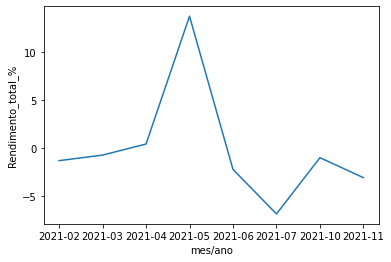

In [159]:
sns.lineplot( x=df_grouped['mes/ano'], y=df_grouped['Rendimento_total_%'])

<AxesSubplot:xlabel='mes/ano', ylabel='Ganho_total'>

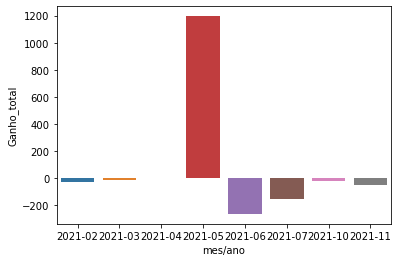

In [161]:
sns.barplot( x=df_grouped['mes/ano'], y=df_grouped['Ganho_total'])

In [167]:
df_ordered

,name,situation,data_compra_1,Preço_médio_comprado,Preço_médio_vendido,Ganho_total,Rendimento_total_%,Rendimento_ultimos_7_dias,Rendimento_ultimos_14_dias,Rendimento_ultimos_30_dias,...,cresc_mm9_ultimos_60_dias,cresc_mm20_ultimos_7_dias,cresc_mm20_ultimos_14_dias,cresc_mm20_ultimos_30_dias,cresc_mm20_ultimos_60_dias,cresc_mm72_ultimos_7_dias,cresc_mm72_ultimos_14_dias,cresc_mm72_ultimos_30_dias,cresc_mm72_ultimos_60_dias,mes/ano
39,PETR4.SA,2 históricos,2021-02-25,23.560,23.260,-30.600,-1.29,-18.46,-19.87,-24.85,...,0.00,-3.21,-5.57,-5.24,0.00,0.00,0.00,0.00,0.00,2021-02
21,SULA4.SA,Vendida,2021-03-05,10.300,10.830,0.530,4.89,-3.39,-10.81,-17.95,...,0.00,-4.46,-8.55,-13.01,0.00,0.00,0.00,0.00,0.00,2021-03
18,PCAR3.SA,Vendida,2021-03-05,41.400,40.520,-0.880,-2.17,104.06,97.67,120.13,...,0.00,27.93,33.96,43.43,0.00,0.00,0.00,0.00,0.00,2021-03
20,RAPT4.SA,Vendida,2021-03-05,14.500,14.490,-0.010,-0.07,1.77,-7.75,-10.01,...,0.00,-2.84,-5.52,-11.61,0.00,0.00,0.00,0.00,0.00,2021-03
16,ENGI4.SA,Vendida,2021-03-05,7.170,7.360,0.190,2.58,0.14,-13.22,-13.11,...,0.00,-3.85,-7.41,-8.54,0.00,0.00,0.00,0.00,0.00,2021-03
29,CSAN3.SA,Comprada,2021-03-05,0.000,87.650,0.000,0.00,9.09,6.17,11.39,...,0.00,2.93,5.50,6.57,0.00,0.00,0.00,0.00,0.00,2021-03
17,MULT3.SA,Vendida,2021-03-05,23.610,25.920,2.310,8.91,6.47,0.14,0.90,...,0.00,-1.42,-2.35,-7.96,0.00,0.00,0.00,0.00,0.00,2021-03
33,MRFG3.SA,Comprada,2021-03-05,0.000,18.640,0.000,0.00,5.64,2.11,9.58,...,0.00,2.86,4.35,1.41,0.00,0.00,0.00,0.00,0.00,2021-03
32,LEVE3.SA,Comprada,2021-03-05,0.000,23.800,0.000,0.00,0.72,-3.97,-10.77,...,0.00,-2.12,-4.64,-9.76,0.00,0.00,0.00,0.00,0.00,2021-03
44,TASA4.SA,Vendida,2021-03-15,21.260,24.290,3.030,12.47,16.36,20.79,44.29,...,31.90,7.33,11.41,19.88,0.00,0.00,0.00,0.00,0.00,2021-03


# modelagem

In [20]:
df_ordered['lucro'] = 0
df_ordered.loc[df_ordered['Ganho_total'] > 0 , 'lucro'] = 1

In [171]:
df_ordered

,name,situation,data_compra_1,Preço_médio_comprado,Preço_médio_vendido,Ganho_total,Rendimento_total_%,Rendimento_ultimos_7_dias,Rendimento_ultimos_14_dias,Rendimento_ultimos_30_dias,...,cresc_mm20_ultimos_7_dias,cresc_mm20_ultimos_14_dias,cresc_mm20_ultimos_30_dias,cresc_mm20_ultimos_60_dias,cresc_mm72_ultimos_7_dias,cresc_mm72_ultimos_14_dias,cresc_mm72_ultimos_30_dias,cresc_mm72_ultimos_60_dias,mes/ano,lucro
39,PETR4.SA,2 históricos,2021-02-25,23.560,23.260,-30.600,-1.29,-18.46,-19.87,-24.85,...,-3.21,-5.57,-5.24,0.00,0.00,0.00,0.00,0.00,2021-02,0
21,SULA4.SA,Vendida,2021-03-05,10.300,10.830,0.530,4.89,-3.39,-10.81,-17.95,...,-4.46,-8.55,-13.01,0.00,0.00,0.00,0.00,0.00,2021-03,1
18,PCAR3.SA,Vendida,2021-03-05,41.400,40.520,-0.880,-2.17,104.06,97.67,120.13,...,27.93,33.96,43.43,0.00,0.00,0.00,0.00,0.00,2021-03,0
20,RAPT4.SA,Vendida,2021-03-05,14.500,14.490,-0.010,-0.07,1.77,-7.75,-10.01,...,-2.84,-5.52,-11.61,0.00,0.00,0.00,0.00,0.00,2021-03,0
16,ENGI4.SA,Vendida,2021-03-05,7.170,7.360,0.190,2.58,0.14,-13.22,-13.11,...,-3.85,-7.41,-8.54,0.00,0.00,0.00,0.00,0.00,2021-03,1
29,CSAN3.SA,Comprada,2021-03-05,0.000,87.650,0.000,0.00,9.09,6.17,11.39,...,2.93,5.50,6.57,0.00,0.00,0.00,0.00,0.00,2021-03,0
17,MULT3.SA,Vendida,2021-03-05,23.610,25.920,2.310,8.91,6.47,0.14,0.90,...,-1.42,-2.35,-7.96,0.00,0.00,0.00,0.00,0.00,2021-03,1
33,MRFG3.SA,Comprada,2021-03-05,0.000,18.640,0.000,0.00,5.64,2.11,9.58,...,2.86,4.35,1.41,0.00,0.00,0.00,0.00,0.00,2021-03,0
32,LEVE3.SA,Comprada,2021-03-05,0.000,23.800,0.000,0.00,0.72,-3.97,-10.77,...,-2.12,-4.64,-9.76,0.00,0.00,0.00,0.00,0.00,2021-03,0
44,TASA4.SA,Vendida,2021-03-15,21.260,24.290,3.030,12.47,16.36,20.79,44.29,...,7.33,11.41,19.88,0.00,0.00,0.00,0.00,0.00,2021-03,1


In [21]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics

import pickle
from sklearn.ensemble import RandomForestRegressor

In [22]:
df_ordered.columns

Index(['name', 'data_compra_1', 'Preço_médio_comprado', 'Preço_médio_vendido',
       'Ganho_total', 'Rendimento_total_%', 'Rendimento_ultimos_7_dias',
       'Rendimento_ultimos_14_dias', 'Rendimento_ultimos_30_dias',
       'Rendimento_ultimos_60_dias', 'Rendimento_ultimos_90_dias',
       'crescimento_vol_ultimos_7_dias', 'crescimento_vol_ultimos_14_dias',
       'crescimento_vol_ultimos_30_dias', 'crescimento_vol_ultimos_60_dias',
       'crescimento_vol_ultimos_90_dias', 'rsi', 'cresc_rsi_ultimos_7_dias',
       'cresc_rsi_ultimos_14_dias', 'cresc_rsi_ultimos_30_dias',
       'cresc_rsi_ultimos_60_dias', 'delta_bolinger_0', 'cresc_bolinger_up_7',
       'cresc_bolinger_down_7', 'cruzou_mm', 'direcao_cruzada_mm_cima',
       'cresc_mm9_ultimos_7_dias', 'cresc_mm9_ultimos_14_dias',
       'cresc_mm9_ultimos_30_dias', 'cresc_mm9_ultimos_60_dias',
       'cresc_mm20_ultimos_7_dias', 'cresc_mm20_ultimos_14_dias',
       'cresc_mm20_ultimos_30_dias', 'cresc_mm20_ultimos_60_dias',
      

In [23]:
df_ordered = df_ordered.fillna(0).replace(-np.inf, 0)

In [185]:
df_ordered

,name,situation,data_compra_1,Preço_médio_comprado,Preço_médio_vendido,Ganho_total,Rendimento_total_%,Rendimento_ultimos_7_dias,Rendimento_ultimos_14_dias,Rendimento_ultimos_30_dias,...,cresc_mm20_ultimos_7_dias,cresc_mm20_ultimos_14_dias,cresc_mm20_ultimos_30_dias,cresc_mm20_ultimos_60_dias,cresc_mm72_ultimos_7_dias,cresc_mm72_ultimos_14_dias,cresc_mm72_ultimos_30_dias,cresc_mm72_ultimos_60_dias,mes/ano,lucro
39,PETR4.SA,2 históricos,2021-02-25,23.560,23.260,-30.600,-1.29,-18.46,-19.87,-24.85,...,-3.21,-5.57,-5.24,0.00,0.00,0.00,0.00,0.00,2021-02,0
21,SULA4.SA,Vendida,2021-03-05,10.300,10.830,0.530,4.89,-3.39,-10.81,-17.95,...,-4.46,-8.55,-13.01,0.00,0.00,0.00,0.00,0.00,2021-03,1
18,PCAR3.SA,Vendida,2021-03-05,41.400,40.520,-0.880,-2.17,104.06,97.67,120.13,...,27.93,33.96,43.43,0.00,0.00,0.00,0.00,0.00,2021-03,0
20,RAPT4.SA,Vendida,2021-03-05,14.500,14.490,-0.010,-0.07,1.77,-7.75,-10.01,...,-2.84,-5.52,-11.61,0.00,0.00,0.00,0.00,0.00,2021-03,0
16,ENGI4.SA,Vendida,2021-03-05,7.170,7.360,0.190,2.58,0.14,-13.22,-13.11,...,-3.85,-7.41,-8.54,0.00,0.00,0.00,0.00,0.00,2021-03,1
29,CSAN3.SA,Comprada,2021-03-05,0.000,87.650,0.000,0.00,9.09,6.17,11.39,...,2.93,5.50,6.57,0.00,0.00,0.00,0.00,0.00,2021-03,0
17,MULT3.SA,Vendida,2021-03-05,23.610,25.920,2.310,8.91,6.47,0.14,0.90,...,-1.42,-2.35,-7.96,0.00,0.00,0.00,0.00,0.00,2021-03,1
33,MRFG3.SA,Comprada,2021-03-05,0.000,18.640,0.000,0.00,5.64,2.11,9.58,...,2.86,4.35,1.41,0.00,0.00,0.00,0.00,0.00,2021-03,0
32,LEVE3.SA,Comprada,2021-03-05,0.000,23.800,0.000,0.00,0.72,-3.97,-10.77,...,-2.12,-4.64,-9.76,0.00,0.00,0.00,0.00,0.00,2021-03,0
44,TASA4.SA,Vendida,2021-03-15,21.260,24.290,3.030,12.47,16.36,20.79,44.29,...,7.33,11.41,19.88,0.00,0.00,0.00,0.00,0.00,2021-03,1


In [24]:
X = df_ordered.drop(['name', 'data_compra_1','mes/ano','Ganho_total','Rendimento_total_%','lucro','Preço_médio_comprado','Preço_médio_vendido'],axis=1)
y = df_ordered['lucro']

In [25]:
# divisão entre treino e teste 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [26]:
# Random Forest Regressor MVP
regr = RandomForestRegressor(random_state=42)
regr.fit(X_train,y_train)
predictions = regr.predict(X_test)

In [27]:
predictions

array([0.134     , 0.315     , 0.76      , 0.37066667, 0.73666667,
       0.3       , 0.57916667, 0.27      , 0.4815    , 0.47583333,
       0.6675    , 0.2925    , 0.75133333, 0.14733333])

In [28]:
print('MAE:', round(metrics.mean_absolute_error(y_test, predictions),2))
print('MSE:', round(metrics.mean_squared_error(y_test, predictions),2))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2))
print('R²:', round(metrics.r2_score(y_test, predictions),2))

MAE: 0.49
MSE: 0.29
RMSE: 0.54
R²: -0.17


In [29]:
comparar = pd.DataFrame(y_test)
comparar['previsto'] = predictions

In [30]:
comparar['dif'] = comparar['previsto'] - comparar['lucro']

In [31]:
comparar.loc[comparar['dif'] > 0.5]

,lucro,previsto,dif
25,0,0.760000,0.760000
23,0,0.751333,0.751333


In [32]:
comparar.loc[comparar['dif'] < -0.5]

,lucro,previsto,dif
15,1,0.315000,-0.685000
27,1,0.270000,-0.730000
14,1,0.147333,-0.852667


In [33]:
erros = len(comparar.loc[comparar['dif'] > 0.5]) + len(comparar.loc[comparar['dif'] < -0.5])

In [34]:
total = len(comparar)

In [35]:
precision_model = round(1 - (erros / total),2)

In [36]:
precision_model

0.64

errei 5 de 14

In [39]:
def rank( X, y):
    """
    Gets a rank of relation of features to target
    The output is a list of combination of features order by relevance by 'RF rank'
    
    :param X: Train data without target
    :param y: Target
    
    """

    X = X
    y = y
    # estimators
    rank = pd.DataFrame({'features': X.columns})


    rfr = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
    rfr.fit(X, y)
    rank['RFR'] = (rfr.feature_importances_ * 100)

    print(rank.sort_values('RFR', ascending=False))

    # opções de listas de features selecionadas para cada estimador
    lista_comb_feat_RFR = []
    #for x in range(2, 11):
    for x in range(2, len(rank)):
        lista_comb_feat_RFR.append(rank.sort_values('RFR', ascending=False).head(x)['features'].tolist())

    return lista_comb_feat_RFR , rank.sort_values('RFR', ascending=False)

In [40]:
features, rank = rank(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


building tree 1 of 50building tree 2 of 50
building tree 3 of 50
building tree 4 of 50

building tree 5 of 50building tree 6 of 50

building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50building tree 11 of 50

building tree 12 of 50
building tree 13 of 50building tree 14 of 50

building tree 15 of 50
building tree 16 of 50building tree 17 of 50

building tree 18 of 50building tree 19 of 50

building tree 20 of 50
building tree 21 of 50building tree 22 of 50building tree 23 of 50


building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50building tree 29 of 50

building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50building tree 37 of 50

building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50building tree 43 of 50

building tree 44 of 

In [41]:
rank['features'].head(10).reset_index(drop=True)

0         Rendimento_ultimos_90_dias
1         Rendimento_ultimos_60_dias
2          cresc_rsi_ultimos_14_dias
3          cresc_mm9_ultimos_60_dias
4              cresc_bolinger_down_7
5         Rendimento_ultimos_14_dias
6    crescimento_vol_ultimos_90_dias
7          Rendimento_ultimos_7_dias
8           cresc_rsi_ultimos_7_dias
9                   delta_bolinger_0
Name: features, dtype: object

# Tentando gerar lista com dados de input com todas ações da bolsa

In [3]:
lista = get_data()

In [4]:
lista

OrderedDict([(0,
              {'GFSA3': {'cotacao': '2,51',
                'P/L': '-588,60',
                'P/VP': '0,52',
                'PSR': '0,731',
                'DY': '0,00%',
                'P/Ativo': '0,209',
                'P/Cap.Giro': '0,71',
                'P/EBIT': '9,09',
                'P/Ativ.Circ.Liq.': '2,40',
                'EV/EBIT': '17,26',
                'EBITDA': '15,34',
                'Mrg. Ebit': '8,04%',
                'Mrg.Liq.': '-0,10%',
                'Liq.Corr.': '1,75',
                'ROIC': '2,65%',
                'ROE': '-0,09%',
                'Liq.2m.': '20.665.600,00',
                'Pat.Liq': '1.630.560.000,00',
                'Div.Brut/Pat.': '0,78',
                'Cresc.5a': '18,80%'}}),
             (1,
              {'DASA3': {'cotacao': '40,29',
                'P/L': '-365,51',
                'P/VP': '3,04',
                'PSR': '2,379',
                'DY': '0,62%',
                'P/Ativo': '1,242',
        

In [52]:
top_ativos

,name
0,BIOM3
1,EUCA3
2,EUCA4
3,BMEB3
4,BMEB4
...,...
364,VALE3
365,BFRE11
366,BFRE12
367,ENMA3B


In [5]:
todos = pd.DataFrame(flatten(lista).keys()).transpose()
todos.columns = todos.iloc[0]
for i in range(len(lista)):
    todos = pd.concat([todos,pd.DataFrame(lista[i]).transpose()])

todos = todos.iloc[1:]
todos['name'] = (todos.index + '.SA' )



2021-10-21 18:29:24.881 NumExpr defaulting to 4 threads.


# opção de trazer dados de nome da ação da planilha mira

In [83]:
lista = top_ativos.copy()

In [84]:
lista

,name
0,BIOM3
1,EUCA3
2,EUCA4
3,BMEB3
4,BMEB4
...,...
364,VALE3
365,BFRE11
366,BFRE12
367,ENMA3B


In [53]:
top_ativos['name'] =top_ativos['name'] + '.SA' 

In [68]:
list(top_ativos['name'])[0]

'BIOM3'

In [81]:
list(todos['name'])

['GFSA3.SA',
 'DASA3.SA',
 'MAPT4.SA',
 'CBEE3.SA',
 'SBFG3.SA',
 'WEST3.SA',
 'AMER3.SA',
 'NORD3.SA',
 'OMGE3.SA',
 'CVCB3.SA',
 'HBSA3.SA',
 'ELMD3.SA',
 'HBRE3.SA',
 'TELB3.SA',
 'ORVR3.SA',
 'OPCT3.SA',
 'EMBR3.SA',
 'ECPR3.SA',
 'TCNO3.SA',
 'SMFT3.SA',
 'ECOR3.SA',
 'DTCY3.SA',
 'TCNO4.SA',
 'TXRX3.SA',
 'BIOM3.SA',
 'TELB4.SA',
 'FRIO3.SA',
 'MEAL3.SA',
 'MBLY3.SA',
 'BLUT3.SA',
 'VLID3.SA',
 'MSPA3.SA',
 'MSPA4.SA',
 'IRBR3.SA',
 'BAHI3.SA',
 'ALPK3.SA',
 'AMAR3.SA',
 'PINE4.SA',
 'GSHP3.SA',
 'BKBR3.SA',
 'TXRX4.SA',
 'AHEB3.SA',
 'ADHM3.SA',
 'OIBR4.SA',
 'AZUL4.SA',
 'BLUT4.SA',
 'CTNM3.SA',
 'SGPS3.SA',
 'CEED3.SA',
 'SHOW3.SA',
 'CRDE3.SA',
 'AHEB5.SA',
 'ESTR4.SA',
 'OIBR3.SA',
 'VIVR3.SA',
 'TCSA3.SA',
 'PMAM3.SA',
 'GOLL4.SA',
 'AVLL3.SA',
 'BAHI11.SA',
 'PLAS3.SA',
 'CTNM4.SA',
 'HOOT4.SA',
 'JFEN3.SA',
 'BBRK3.SA',
 'COGN3.SA',
 'ATMP3.SA',
 'INEP4.SA',
 'INEP3.SA',
 'MTIG4.SA',
 'RPMG3.SA',
 'IGBR3.SA',
 'BDLL4.SA',
 'BDLL3.SA',
 'SNSY5.SA',
 'PDGR3.SA',
 'HETA3.SA'

In [45]:
data = yf.download(list(todos['name']),start=date_year_ago)

[*********************100%***********************]  478 of 478 completed

6 Failed downloads:
- BAHI11.SA: No data found for this date range, symbol may be delisted
- GETT4.SA: None
- MODL3.SA: None
- MODL4.SA: None
- BTTL3.SA: No data found, symbol may be delisted
- GETT3.SA: None


In [55]:
date_year_ago = dt.datetime.today() - dt.timedelta(days=300)
date_year_ago = date_year_ago.strftime(format='20%y-%m-%d')

In [56]:
data = yf.download(list(top_ativos['name']),start=date_year_ago)

[*********************100%***********************]  369 of 369 completed

28 Failed downloads:
- BFRE12.SA: No data found, symbol may be delisted
- TIET4.SA: No data found, symbol may be delisted
- PCAR4.SA: No data found, symbol may be delisted
- BRBI4.SA: No data found, symbol may be delisted
- BSEV3.SA: No data found, symbol may be delisted
- BPAR3.SA: No data found, symbol may be delisted
- ENMA3B.SA: No data found, symbol may be delisted
- TIET11.SA: No data found, symbol may be delisted
- CEEB6.SA: No data found, symbol may be delisted
- BBML3.SA: No data found, symbol may be delisted
- BPAT33.SA: No data found, symbol may be delisted
- BFRE11.SA: No data found for this date range, symbol may be delisted
- CPRE3.SA: No data found, symbol may be delisted
- TESA3.SA: No data found, symbol may be delisted
- RANI4.SA: No data found, symbol may be delisted
- LTEL3B.SA: No data found, symbol may be delisted
- LINX3.SA: No data found, symbol may be delisted
- MSRO3.SA: No data found, sy

In [87]:

df_filled = pd.DataFrame(columns = ['name'])
df_filled['name'] = lista['name']

In [105]:

df_filled['ativo'] = df_filled['name']
df_filled = df_filled.set_index('ativo')


In [106]:
df_filled

,name,idx
ativo,,
BIOM3,BIOM3,BIOM3
EUCA3,EUCA3,EUCA3
EUCA4,EUCA4,EUCA4
BMEB3,BMEB3,BMEB3
BMEB4,BMEB4,BMEB4
...,...,...
VALE3,VALE3,VALE3
BFRE11,BFRE11,BFRE11
BFRE12,BFRE12,BFRE12


,name,idx
index,,
BIOM3,BIOM3,BIOM3
EUCA3,EUCA3,EUCA3
EUCA4,EUCA4,EUCA4
BMEB3,BMEB3,BMEB3
BMEB4,BMEB4,BMEB4
...,...,...
VALE3,VALE3,VALE3
BFRE11,BFRE11,BFRE11
BFRE12,BFRE12,BFRE12


In [48]:
# lógica para saber se houve compra e venda ou somente compra, apartir daqui o pressuposto de que houve o trade, se não só hold

#df_filled['Preço_médio_comprado'] = 0
#df_filled['Preço_médio_vendido'] = 0
#df_filled['Ganho_total'] = 0
#df_filled['Rendimento_total_%'] = 0

def inputer_data(data, df_filled):
    lista = list(df_filled.index)
    for i in range(len(df_filled)):
        dados_acao = pd.DataFrame(data.loc[ : , (['Open','High','Low','Close','Adj Close','Volume'],lista[i]+".SA")])
        dados_acao_filtrado = dados_acao.copy()
        #RENDIMENTO ULTIMOS X DIAS (ONTEM X DIA COMPARADO)
        #valor da ultima cotação
        cotacao_last = dados_acao_filtrado['Close'][-1:][lista[i]+".SA"][0]
        #valor cotação x dias atras
        try:
            cotacao_7 = dados_acao_filtrado['Close'][-7:-6][lista[i]+".SA"][0]
            cotacao_14 = dados_acao_filtrado['Close'][-14:-13][lista[i]+".SA"][0]
            cotacao30 = dados_acao_filtrado['Close'][-30:-29][lista[i]+".SA"][0]
            cotacao_60 = dados_acao_filtrado['Close'][-60:-59][lista[i]+".SA"][0]
            cotacao_90 = dados_acao_filtrado['Close'][-90:-89][lista[i]+".SA"][0]
            #% da queda ou aumento ultimos x dias
            crescimento_7 = round(((cotacao_last - cotacao_7) / cotacao_7) * 100,2)
            crescimento_14 = round(((cotacao_last - cotacao_14) / cotacao_14) * 100,2)
            crescimento_30 = round(((cotacao_last - cotacao30) / cotacao30) * 100,2)
            crescimento_60 = round(((cotacao_last - cotacao_60) / cotacao_60) * 100,2)
            crescimento_90 = round(((cotacao_last - cotacao_90) / cotacao_90) * 100,2)
        except:
            exit
        #CRESCIMENTO VOLUME ULTIMOS X DIAS (ONTEM X DIA COMPARADO)
        #volume do dia anterior a compra
        volume_last = dados_acao_filtrado['Volume'][-1:][lista[i]+".SA"][0]
        #valor cotação x dias atras
        try:
            volume_7 = dados_acao_filtrado['Volume'][-7:-6][lista[i]+".SA"][0]
            volume_14 = dados_acao_filtrado['Volume'][-14:-13][lista[i]+".SA"][0]
            volume30 = dados_acao_filtrado['Volume'][-30:-29][lista[i]+".SA"][0]
            volume_60 = dados_acao_filtrado['Volume'][-60:-59][lista[i]+".SA"][0]
            volume_90 = dados_acao_filtrado['Volume'][-90:-89][lista[i]+".SA"][0]
            #% da queda ou aumento ultimos x dias
            crescimento_vol_7 = round(((volume_last - volume_7) / volume_7) * 100,2)
            crescimento_vol_14 = round(((volume_last - volume_14) / volume_14) * 100,2)
            crescimento_vol_30 = round(((volume_last - volume30) / volume30) * 100,2)
            crescimento_vol_60 = round(((volume_last - volume_60) / volume_60) * 100,2)
            crescimento_vol_90 = round(((volume_last - volume_90) / volume_90) * 100,2)
        except:
            exit
        #RSI
        try:
            delta = dados_acao_filtrado['Close'][-90:].diff()
            up, down = delta.copy(), delta.copy()
            up[up < 0] = 0
            down[down > 0] = 0
            period = 14
            rUp = up.ewm(com=period - 1,  adjust=False).mean()
            rDown = down.ewm(com=period - 1, adjust=False).mean().abs()
            delta['RSI'] = 100 - 100 / (1 + rUp / rDown).fillna(0)

            rsi_0 = delta['RSI'][-1:][0]
            rsi_7 = delta['RSI'][-7:-6][0]
            rsi_14 = delta['RSI'][-14:-13][0]
            rsi_30 = delta['RSI'][-30:-29][0]
            rsi_60 = delta['RSI'][-60:-59][0]

            #% da queda ou aumento ultimos x dias
            cresc_rsi_7 = round(((rsi_0 - rsi_7) / rsi_7) * 100,2)
            cresc_rsi_14 = round(((rsi_0 - rsi_14) / rsi_14) * 100,2)
            cresc_rsi_30 = round(((rsi_0 - rsi_30) / rsi_30) * 100,2)
            cresc_rsi_60 = round(((rsi_0 - rsi_60) / rsi_60) * 100,2)
        except:
            exit
        #BOLINGER
        try:
            bolinger = dados_acao_filtrado.copy()
            bolinger['MA20'] = dados_acao_filtrado['Close'].rolling(20).mean()
            bolinger['20 Day STD'] = bolinger['Close'].rolling(window=20).std()
            bolinger['Upper Band'] = bolinger['MA20'] + (bolinger['20 Day STD'] * 2)
            bolinger['Lower Band'] = bolinger['MA20'] - (bolinger['20 Day STD'] * 2)

            boolinger_up_0 = bolinger['Upper Band'][-1:][0]
            boolinger_down_0 = bolinger['Lower Band'][-1:][0]
            boolinger_up_7 = bolinger['Upper Band'][-7:-6][0]
            boolinger_down_7 = bolinger['Lower Band'][-7:-6][0]

            delta_bolinger_0 = round((boolinger_up_0 - boolinger_down_0) / boolinger_down_0 * 100,2)
            cresc_bolinger_up_7 = round((boolinger_up_0 - boolinger_up_7) / boolinger_up_7 * 100,2)
            cresc_bolinger_down_7 = round((boolinger_down_0 - boolinger_down_7) / boolinger_down_7 * 100,2)
        except:
            exit
        #MÉDIAS MOVEIS
        try:
            time = dados_acao_filtrado.copy()
            rolling_9  = time['Close'].rolling(window=9)
            rolling_mean_9 = rolling_9.mean().round(1)

            rolling_20  = time['Close'].rolling(window=20)
            rolling_mean_20 = rolling_20.mean().round(1)

            rolling_72  = time['Close'].rolling(window=72)
            rolling_mean_72 = rolling_72.mean().round(1)
            time['MM9'] = rolling_mean_9.fillna(0)
            time['MM20'] = rolling_mean_20.fillna(0)
            time['MM72'] = rolling_mean_72.fillna(0)
            time['cruzamento'] =  time['MM9'] - time['MM72']
            buy = time.tail(50).loc[(time.tail(50)['cruzamento']==0)]

            if buy.empty == False:
                cruzou_mm = 1
            else:
                cruzou_mm = 0         

            if time['MM72'].iloc[-1] < time['MM9'].iloc[-1]:
                direcao_cruzada_cima = 1
            else:
                direcao_cruzada_cima = 0
                
            mm9_0 = time['MM9'][-1:][0]
            mm9_7 = time['MM9'][-7:-6][0]
            mm9_14 = time['MM9'][-14:-13][0]
            mm9_30 = time['MM9'][-30:-29][0]
            mm9_60 = time['MM9'][-60:-59][0]

            mm20_0 = time['MM20'][-1:][0]
            mm20_7 = time['MM20'][-7:-6][0]
            mm20_14 = time['MM20'][-14:-13][0]
            mm20_30 = time['MM20'][-30:-29][0]
            mm20_60 = time['MM20'][-60:-59][0]

            mm72_0 = time['MM72'][-1:][0]
            mm72_7 = time['MM72'][-7:-6][0]
            mm72_14 = time['MM72'][-14:-13][0]
            mm72_30 = time['MM72'][-30:-29][0]
            mm72_60 = time['MM72'][-60:-59][0]

            #% da queda ou aumento ultimos x dias
            cresc_mm9_7 = round(((mm9_0 - mm9_7) / mm9_7) * 100,2)
            cresc_mm9_14 = round(((mm9_0 - mm9_14) / mm9_14) * 100,2)
            cresc_mm9_30 = round(((mm9_0 - mm9_30) / mm9_30) * 100,2)
            cresc_mm9_60 = round(((mm9_0 - mm9_60) / mm9_60) * 100,2)

            #% da queda ou aumento ultimos x dias
            cresc_mm20_7 = round(((mm20_0 - mm20_7) / mm20_7) * 100,2)
            cresc_mm20_14 = round(((mm20_0 - mm20_14) / mm20_14) * 100,2)
            cresc_mm20_30 = round(((mm20_0 - mm20_30) / mm20_30) * 100,2)
            cresc_mm20_60 = round(((mm20_0 - mm20_60) / mm20_60) * 100,2)

            #% da queda ou aumento ultimos x dias
            cresc_mm72_7 = round(((mm72_0 - mm72_7) / mm72_7) * 100,2)
            cresc_mm72_14 = round(((mm72_0 - mm72_14) / mm72_14) * 100,2)
            cresc_mm72_30 = round(((mm72_0 - mm72_30) / mm72_30) * 100,2)
            cresc_mm72_60 = round(((mm72_0 - mm72_60) / mm72_60) * 100,2)

        except:
            exit
        try:
        #Atribuições
            #df_filled.loc[df_filled['name'].str.contains(lista[i]),'data_compra_1'] = data_compra_1
            #df_filled.loc[df_filled['name'].str.contains(lista[i]),'Preço_médio_comprado'] = preco_medio_compra
            #df_filled.loc[df_filled['name'].str.contains(lista[i]),'Preço_médio_vendido'] = preco_medio_vendido
            #df_filled.loc[df_filled['name'].str.contains(lista[i]),'Ganho_total'] = Ganho_total

            #df_filled.loc[df_filled['name'].str.contains(lista[i]),'Setor'] = setor
            #df_filled.loc[df_filled['name'].str.contains(lista[i]),'Atividade'] = atividade

            #df_filled.loc[df_filled['name'].str.contains(lista[i]),'Rendimento_total_%'] = rendimento_total
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Rendimento_ultimos_7_dias'] = crescimento_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Rendimento_ultimos_14_dias'] = crescimento_14
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Rendimento_ultimos_30_dias'] = crescimento_30
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Rendimento_ultimos_60_dias'] = crescimento_60
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'Rendimento_ultimos_90_dias'] = crescimento_90

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'crescimento_vol_ultimos_7_dias'] = crescimento_vol_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'crescimento_vol_ultimos_14_dias'] = crescimento_vol_14
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'crescimento_vol_ultimos_30_dias'] = crescimento_vol_30
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'crescimento_vol_ultimos_60_dias'] = crescimento_vol_60
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'crescimento_vol_ultimos_90_dias'] = crescimento_vol_90

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'rsi'] = rsi_0
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_rsi_ultimos_7_dias'] = cresc_rsi_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_rsi_ultimos_14_dias'] = cresc_rsi_14
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_rsi_ultimos_30_dias'] = cresc_rsi_30
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_rsi_ultimos_60_dias'] = cresc_rsi_60

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'delta_bolinger_0'] = delta_bolinger_0
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_bolinger_up_7'] = cresc_bolinger_up_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_bolinger_down_7'] = cresc_bolinger_down_7

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cruzou_mm'] = cruzou_mm
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'direcao_cruzada_mm_cima'] = direcao_cruzada_cima

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm9_ultimos_7_dias'] = cresc_mm9_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm9_ultimos_14_dias'] = cresc_mm9_14
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm9_ultimos_30_dias'] = cresc_mm9_30
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm9_ultimos_60_dias'] = cresc_mm9_60

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm20_ultimos_7_dias'] = cresc_mm20_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm20_ultimos_14_dias'] = cresc_mm20_14
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm20_ultimos_30_dias'] = cresc_mm20_30
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm20_ultimos_60_dias'] = cresc_mm20_60        

            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm72_ultimos_7_dias'] = cresc_mm72_7
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm72_ultimos_14_dias'] = cresc_mm72_14
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm72_ultimos_30_dias'] = cresc_mm72_30
            df_filled.loc[df_filled['name'].str.contains(lista[i]),'cresc_mm72_ultimos_60_dias'] = cresc_mm72_60

            
        except:
            exit
        
    return df_filled


In [49]:
df_filled = inputer_data(data, df_filled)

In [122]:
df_filled

,name,data_compra_1,Preço_médio_comprado,Preço_médio_vendido,Ganho_total,Rendimento_total_%,Rendimento_ultimos_7_dias,Rendimento_ultimos_14_dias,Rendimento_ultimos_30_dias,Rendimento_ultimos_60_dias,...,cresc_mm9_ultimos_30_dias,cresc_mm9_ultimos_60_dias,cresc_mm20_ultimos_7_dias,cresc_mm20_ultimos_14_dias,cresc_mm20_ultimos_30_dias,cresc_mm20_ultimos_60_dias,cresc_mm72_ultimos_7_dias,cresc_mm72_ultimos_14_dias,cresc_mm72_ultimos_30_dias,cresc_mm72_ultimos_60_dias
GFSA3,GFSA3.SA,10/03/2021,10.4,10.2,-20.0,-1.96,-2.66,-3.03,-15.79,-36.00,...,-16.13,-38.10,-3.57,-6.90,-12.90,-37.21,-2.94,-8.33,-17.50,inf
DASA3,DASA3.SA,NaN,NaN,NaN,NaN,NaN,-5.22,-4.18,-16.20,-28.01,...,-15.57,-26.69,-2.26,-5.88,-15.29,-27.64,-3.10,-6.54,-12.74,inf
MAPT4,MAPT4.SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CBEE3,CBEE3.SA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SBFG3,SBFG3.SA,NaN,NaN,NaN,NaN,NaN,-11.07,-8.27,-17.87,-30.29,...,-17.25,-25.53,-3.93,-7.86,-14.33,-23.50,-2.62,-5.10,-7.20,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CASH3,CASH3.SA,NaN,NaN,NaN,NaN,NaN,-21.59,-29.12,-24.49,-64.08,...,-18.75,-52.29,-10.61,-10.61,-21.33,-39.18,-3.61,-5.88,-4.76,inf
LWSA3,LWSA3.SA,NaN,NaN,NaN,NaN,NaN,-3.52,-2.06,-12.81,-21.52,...,-10.98,-17.98,-2.60,-4.66,-8.16,-15.09,-1.62,-3.57,-5.08,inf
BIDI3,BIDI3.SA,NaN,NaN,NaN,NaN,NaN,-11.87,-12.13,-36.77,-46.17,...,-34.19,-44.00,-9.84,-21.05,-28.26,-37.50,-3.95,-6.81,-8.37,inf
BIDI11,BIDI11.SA,NaN,NaN,NaN,NaN,NaN,-9.98,-9.96,-28.55,-43.58,...,-29.04,-42.34,-8.51,-17.48,-24.40,-36.24,-3.70,-6.87,-8.44,inf


In [58]:
df_input = df_filled.fillna(0).replace(np.inf, 0)

In [59]:
df_input

,name,Rendimento_ultimos_7_dias,Rendimento_ultimos_14_dias,Rendimento_ultimos_30_dias,Rendimento_ultimos_60_dias,Rendimento_ultimos_90_dias,crescimento_vol_ultimos_7_dias,crescimento_vol_ultimos_14_dias,crescimento_vol_ultimos_30_dias,crescimento_vol_ultimos_60_dias,...,cresc_mm9_ultimos_30_dias,cresc_mm9_ultimos_60_dias,cresc_mm20_ultimos_7_dias,cresc_mm20_ultimos_14_dias,cresc_mm20_ultimos_30_dias,cresc_mm20_ultimos_60_dias,cresc_mm72_ultimos_7_dias,cresc_mm72_ultimos_14_dias,cresc_mm72_ultimos_30_dias,cresc_mm72_ultimos_60_dias
GFSA3,GFSA3.SA,-2.66,-3.03,-15.79,-36.00,-46.67,10.54,154.40,584.44,202.22,...,-16.13,-38.10,-3.57,-6.90,-12.90,-37.21,-2.94,-8.33,-17.50,0.0
DASA3,DASA3.SA,-5.22,-4.18,-16.20,-28.01,-36.64,-18.71,182.73,340.87,1000.40,...,-15.57,-26.69,-2.26,-5.88,-15.29,-27.64,-3.10,-6.54,-12.74,0.0
MAPT4,MAPT4.SA,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
CBEE3,CBEE3.SA,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
SBFG3,SBFG3.SA,-11.07,-8.27,-17.87,-30.29,-30.66,68.06,18.88,96.96,174.02,...,-17.25,-25.53,-3.93,-7.86,-14.33,-23.50,-2.62,-5.10,-7.20,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CASH3,CASH3.SA,-21.59,-29.12,-24.49,-64.08,-28.87,44.60,22.56,142.68,122.48,...,-18.75,-52.29,-10.61,-10.61,-21.33,-39.18,-3.61,-5.88,-4.76,0.0
LWSA3,LWSA3.SA,-3.52,-2.06,-12.81,-21.52,-15.06,86.12,51.64,169.53,38.47,...,-10.98,-17.98,-2.60,-4.66,-8.16,-15.09,-1.62,-3.57,-5.08,0.0
BIDI3,BIDI3.SA,-11.87,-12.13,-36.77,-46.17,-33.16,-58.34,11.51,184.56,253.11,...,-34.19,-44.00,-9.84,-21.05,-28.26,-37.50,-3.95,-6.81,-8.37,0.0
BIDI11,BIDI11.SA,-9.98,-9.96,-28.55,-43.58,-30.07,-60.92,-28.66,160.77,247.09,...,-29.04,-42.34,-8.51,-17.48,-24.40,-36.24,-3.70,-6.87,-8.44,0.0


In [60]:
df_ordered = df_input.fillna(0).replace(-np.inf, 0)

In [61]:
df_ordered

,name,Rendimento_ultimos_7_dias,Rendimento_ultimos_14_dias,Rendimento_ultimos_30_dias,Rendimento_ultimos_60_dias,Rendimento_ultimos_90_dias,crescimento_vol_ultimos_7_dias,crescimento_vol_ultimos_14_dias,crescimento_vol_ultimos_30_dias,crescimento_vol_ultimos_60_dias,...,cresc_mm9_ultimos_30_dias,cresc_mm9_ultimos_60_dias,cresc_mm20_ultimos_7_dias,cresc_mm20_ultimos_14_dias,cresc_mm20_ultimos_30_dias,cresc_mm20_ultimos_60_dias,cresc_mm72_ultimos_7_dias,cresc_mm72_ultimos_14_dias,cresc_mm72_ultimos_30_dias,cresc_mm72_ultimos_60_dias
GFSA3,GFSA3.SA,-2.66,-3.03,-15.79,-36.00,-46.67,10.54,154.40,584.44,202.22,...,-16.13,-38.10,-3.57,-6.90,-12.90,-37.21,-2.94,-8.33,-17.50,0.0
DASA3,DASA3.SA,-5.22,-4.18,-16.20,-28.01,-36.64,-18.71,182.73,340.87,1000.40,...,-15.57,-26.69,-2.26,-5.88,-15.29,-27.64,-3.10,-6.54,-12.74,0.0
MAPT4,MAPT4.SA,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
CBEE3,CBEE3.SA,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
SBFG3,SBFG3.SA,-11.07,-8.27,-17.87,-30.29,-30.66,68.06,18.88,96.96,174.02,...,-17.25,-25.53,-3.93,-7.86,-14.33,-23.50,-2.62,-5.10,-7.20,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CASH3,CASH3.SA,-21.59,-29.12,-24.49,-64.08,-28.87,44.60,22.56,142.68,122.48,...,-18.75,-52.29,-10.61,-10.61,-21.33,-39.18,-3.61,-5.88,-4.76,0.0
LWSA3,LWSA3.SA,-3.52,-2.06,-12.81,-21.52,-15.06,86.12,51.64,169.53,38.47,...,-10.98,-17.98,-2.60,-4.66,-8.16,-15.09,-1.62,-3.57,-5.08,0.0
BIDI3,BIDI3.SA,-11.87,-12.13,-36.77,-46.17,-33.16,-58.34,11.51,184.56,253.11,...,-34.19,-44.00,-9.84,-21.05,-28.26,-37.50,-3.95,-6.81,-8.37,0.0
BIDI11,BIDI11.SA,-9.98,-9.96,-28.55,-43.58,-30.07,-60.92,-28.66,160.77,247.09,...,-29.04,-42.34,-8.51,-17.48,-24.40,-36.24,-3.70,-6.87,-8.44,0.0


In [154]:
X.columns

Index(['Rendimento_ultimos_7_dias', 'Rendimento_ultimos_14_dias',
       'Rendimento_ultimos_30_dias', 'Rendimento_ultimos_60_dias',
       'Rendimento_ultimos_90_dias', 'crescimento_vol_ultimos_7_dias',
       'crescimento_vol_ultimos_14_dias', 'crescimento_vol_ultimos_30_dias',
       'crescimento_vol_ultimos_60_dias', 'crescimento_vol_ultimos_90_dias',
       'rsi', 'cresc_rsi_ultimos_7_dias', 'cresc_rsi_ultimos_14_dias',
       'cresc_rsi_ultimos_30_dias', 'cresc_rsi_ultimos_60_dias',
       'delta_bolinger_0', 'cresc_bolinger_up_7', 'cresc_bolinger_down_7',
       'cruzou_mm', 'direcao_cruzada_mm_cima', 'cresc_mm9_ultimos_7_dias',
       'cresc_mm9_ultimos_14_dias', 'cresc_mm9_ultimos_30_dias',
       'cresc_mm9_ultimos_60_dias', 'cresc_mm20_ultimos_7_dias',
       'cresc_mm20_ultimos_14_dias', 'cresc_mm20_ultimos_30_dias',
       'cresc_mm20_ultimos_60_dias', 'cresc_mm72_ultimos_7_dias',
       'cresc_mm72_ultimos_14_dias', 'cresc_mm72_ultimos_30_dias',
       'cresc_mm72_ultimos

In [156]:
df_ordered[['Rendimento_ultimos_7_dias', 'Rendimento_ultimos_14_dias',
       'Rendimento_ultimos_30_dias', 'Rendimento_ultimos_60_dias',
       'Rendimento_ultimos_90_dias', 'crescimento_vol_ultimos_7_dias',
       'crescimento_vol_ultimos_14_dias', 'crescimento_vol_ultimos_30_dias',
       'crescimento_vol_ultimos_60_dias', 'crescimento_vol_ultimos_90_dias',
       'rsi', 'cresc_rsi_ultimos_7_dias', 'cresc_rsi_ultimos_14_dias',
       'cresc_rsi_ultimos_30_dias', 'cresc_rsi_ultimos_60_dias',
       'delta_bolinger_0', 'cresc_bolinger_up_7', 'cresc_bolinger_down_7',
       'cruzou_mm', 'direcao_cruzada_mm_cima', 'cresc_mm9_ultimos_7_dias',
       'cresc_mm9_ultimos_14_dias', 'cresc_mm9_ultimos_30_dias',
       'cresc_mm9_ultimos_60_dias', 'cresc_mm20_ultimos_7_dias',
       'cresc_mm20_ultimos_14_dias', 'cresc_mm20_ultimos_30_dias',
       'cresc_mm20_ultimos_60_dias', 'cresc_mm72_ultimos_7_dias',
       'cresc_mm72_ultimos_14_dias', 'cresc_mm72_ultimos_30_dias',
       'cresc_mm72_ultimos_60_dias']]

,Rendimento_ultimos_7_dias,Rendimento_ultimos_14_dias,Rendimento_ultimos_30_dias,Rendimento_ultimos_60_dias,Rendimento_ultimos_90_dias,crescimento_vol_ultimos_7_dias,crescimento_vol_ultimos_14_dias,crescimento_vol_ultimos_30_dias,crescimento_vol_ultimos_60_dias,crescimento_vol_ultimos_90_dias,...,cresc_mm9_ultimos_30_dias,cresc_mm9_ultimos_60_dias,cresc_mm20_ultimos_7_dias,cresc_mm20_ultimos_14_dias,cresc_mm20_ultimos_30_dias,cresc_mm20_ultimos_60_dias,cresc_mm72_ultimos_7_dias,cresc_mm72_ultimos_14_dias,cresc_mm72_ultimos_30_dias,cresc_mm72_ultimos_60_dias
GFSA3,-2.66,-3.03,-15.79,-36.00,-46.67,8.42,149.53,571.34,196.44,386.87,...,-16.13,-38.10,-3.57,-6.90,-12.90,-37.21,-2.94,-8.33,-17.50,0.0
DASA3,-5.22,-4.18,-16.20,-28.01,-36.64,-18.91,182.01,339.74,997.60,130.98,...,-15.57,-26.69,-2.26,-5.88,-15.29,-27.64,-3.10,-6.54,-12.74,0.0
MAPT4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
CBEE3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
SBFG3,-11.07,-8.27,-17.87,-30.29,-30.66,67.55,18.52,96.36,173.19,-8.49,...,-17.25,-25.53,-3.93,-7.86,-14.33,-23.50,-2.62,-5.10,-7.20,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CASH3,-21.59,-29.12,-24.49,-64.08,-28.87,42.33,20.63,138.88,118.99,1073.71,...,-18.75,-52.29,-10.61,-10.61,-21.33,-39.18,-3.61,-5.88,-4.76,0.0
LWSA3,-3.52,-2.06,-12.81,-21.52,-15.06,84.21,50.09,166.77,37.05,79.17,...,-10.98,-17.98,-2.60,-4.66,-8.16,-15.09,-1.62,-3.57,-5.08,0.0
BIDI3,-11.87,-12.13,-36.77,-46.17,-33.16,-58.54,10.98,183.20,251.43,290.28,...,-34.19,-44.00,-9.84,-21.05,-28.26,-37.50,-3.95,-6.81,-8.37,0.0
BIDI11,-9.98,-9.96,-28.55,-43.58,-30.07,-60.92,-28.66,160.77,247.09,187.35,...,-29.04,-42.34,-8.51,-17.48,-24.40,-36.24,-3.70,-6.87,-8.44,0.0


In [62]:
input_predict = df_ordered[list(X.columns)]

In [63]:
input_predict

,Rendimento_ultimos_7_dias,Rendimento_ultimos_14_dias,Rendimento_ultimos_30_dias,Rendimento_ultimos_60_dias,Rendimento_ultimos_90_dias,crescimento_vol_ultimos_7_dias,crescimento_vol_ultimos_14_dias,crescimento_vol_ultimos_30_dias,crescimento_vol_ultimos_60_dias,crescimento_vol_ultimos_90_dias,...,cresc_mm9_ultimos_30_dias,cresc_mm9_ultimos_60_dias,cresc_mm20_ultimos_7_dias,cresc_mm20_ultimos_14_dias,cresc_mm20_ultimos_30_dias,cresc_mm20_ultimos_60_dias,cresc_mm72_ultimos_7_dias,cresc_mm72_ultimos_14_dias,cresc_mm72_ultimos_30_dias,cresc_mm72_ultimos_60_dias
GFSA3,-2.66,-3.03,-15.79,-36.00,-46.67,10.54,154.40,584.44,202.22,396.38,...,-16.13,-38.10,-3.57,-6.90,-12.90,-37.21,-2.94,-8.33,-17.50,0.0
DASA3,-5.22,-4.18,-16.20,-28.01,-36.64,-18.71,182.73,340.87,1000.40,131.57,...,-15.57,-26.69,-2.26,-5.88,-15.29,-27.64,-3.10,-6.54,-12.74,0.0
MAPT4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
CBEE3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
SBFG3,-11.07,-8.27,-17.87,-30.29,-30.66,68.06,18.88,96.96,174.02,-8.21,...,-17.25,-25.53,-3.93,-7.86,-14.33,-23.50,-2.62,-5.10,-7.20,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CASH3,-21.59,-29.12,-24.49,-64.08,-28.87,44.60,22.56,142.68,122.48,1092.42,...,-18.75,-52.29,-10.61,-10.61,-21.33,-39.18,-3.61,-5.88,-4.76,0.0
LWSA3,-3.52,-2.06,-12.81,-21.52,-15.06,86.12,51.64,169.53,38.47,81.03,...,-10.98,-17.98,-2.60,-4.66,-8.16,-15.09,-1.62,-3.57,-5.08,0.0
BIDI3,-11.87,-12.13,-36.77,-46.17,-33.16,-58.34,11.51,184.56,253.11,292.15,...,-34.19,-44.00,-9.84,-21.05,-28.26,-37.50,-3.95,-6.81,-8.37,0.0
BIDI11,-9.98,-9.96,-28.55,-43.58,-30.07,-60.92,-28.66,160.77,247.09,187.35,...,-29.04,-42.34,-8.51,-17.48,-24.40,-36.24,-3.70,-6.87,-8.44,0.0


In [64]:
predictions = regr.predict(input_predict)

In [65]:
input_predict['probabilidade de lucro'] = predictions.round(2) * 100

In [67]:
input_predict['probabilidade de lucro'].sort_values(ascending=False).round(2)

SEER3    78.0
BLUT4    76.0
CXSE3    76.0
MLAS3    76.0
PCAR3    76.0
         ... 
TRPL3     9.0
MOAR3     7.0
BAHI3     6.0
WLMM4     6.0
WEGE3     4.0
Name: probabilidade de lucro, Length: 479, dtype: float64

In [159]:
input_predict.loc[input_predict.index == 'MGLU3']

,Rendimento_ultimos_7_dias,Rendimento_ultimos_14_dias,Rendimento_ultimos_30_dias,Rendimento_ultimos_60_dias,Rendimento_ultimos_90_dias,crescimento_vol_ultimos_7_dias,crescimento_vol_ultimos_14_dias,crescimento_vol_ultimos_30_dias,crescimento_vol_ultimos_60_dias,crescimento_vol_ultimos_90_dias,...,cresc_mm9_ultimos_60_dias,cresc_mm20_ultimos_7_dias,cresc_mm20_ultimos_14_dias,cresc_mm20_ultimos_30_dias,cresc_mm20_ultimos_60_dias,cresc_mm72_ultimos_7_dias,cresc_mm72_ultimos_14_dias,cresc_mm72_ultimos_30_dias,cresc_mm72_ultimos_60_dias,probabilidade de lucro
MGLU3,-8.28,-1.51,-29.52,-37.7,-32.63,-34.67,-14.19,95.24,102.06,216.24,...,-38.1,-5.19,-13.61,-23.96,-34.53,-3.12,-6.06,-10.14,0.0,51.0


Inserir shap value para explicar cada decisão  

trazer dados da planilha do mira de investimentos com setor e subsetor de cada empresa em portugues  e substituir função get data com os nomes das ações na lista do mira  

trazer planilhas do mira para o app  

melhorar modelo ( PCA, escolher melhores features, escalonar dados, escolher modelo, garantir que estou treinando e testando com quantidades representativas de ambas as classes preditas lucro ou prejuizo)  



# testar combinação de features para tentar melhorar performance ou outro modelo

# criar dados fake para melhorar o modelo

# testes

In [239]:
dados_acao

,Adj Close,Close,High,Low,Open,Volume
,POMO4.SA,POMO4.SA,POMO4.SA,POMO4.SA,POMO4.SA,POMO4.SA
Date,,,,,,
2020-09-18,2.807800,2.91,2.97,2.89,2.96,5340800.0
2020-09-21,2.682365,2.78,2.88,2.77,2.88,9828400.0
2020-09-22,2.696970,2.77,2.81,2.72,2.79,8563500.0
2020-09-23,2.609343,2.68,2.82,2.68,2.78,8748100.0
2020-09-24,2.648288,2.72,2.77,2.66,2.70,6085000.0
...,...,...,...,...,...,...
2021-09-13,2.740000,2.74,2.76,2.65,2.69,3656800.0
2021-09-14,2.690000,2.69,2.81,2.68,2.74,2967600.0


In [240]:
dados_acao_filtrado

,Adj Close,Close,High,Low,Open,Volume
,POMO4.SA,POMO4.SA,POMO4.SA,POMO4.SA,POMO4.SA,POMO4.SA
Date,,,,,,
2020-09-18,2.807800,2.91,2.97,2.89,2.96,5340800.0
2020-09-21,2.682365,2.78,2.88,2.77,2.88,9828400.0
2020-09-22,2.696970,2.77,2.81,2.72,2.79,8563500.0
2020-09-23,2.609343,2.68,2.82,2.68,2.78,8748100.0
2020-09-24,2.648288,2.72,2.77,2.66,2.70,6085000.0
...,...,...,...,...,...,...
2021-07-21,3.140000,3.14,3.25,3.14,3.22,5406500.0
2021-07-22,3.160000,3.16,3.19,3.12,3.13,2829200.0


In [173]:
df.loc[(df['Código de Negociação'].str.contains('CSMG3F'))].sort_values('Data do Negócio')[-1:]['Data do Negócio'].item()

'29/04/2021'

In [170]:
df.loc[(df['Código de Negociação'].str.contains('CSMG3F'))]

,Data do Negócio,Tipo de Movimentação,Mercado,Prazo/Vencimento,Instituição,Código de Negociação,Quantidade,Preço,Valor
29,01/06/2021,Venda,Mercado Fracionário,-,ORAMA DTVM S A,CSMG3F,1,17.56,17.56
67,29/04/2021,Compra,Mercado Fracionário,-,ORAMA DTVM S A,CSMG3F,1,16.74,16.74
86,23/03/2021,Venda,Mercado Fracionário,-,CLEAR CORRETORA - GRUPO XP,CSMG3F,1,15.25,15.25
92,17/03/2021,Compra,Mercado Fracionário,-,CLEAR CORRETORA - GRUPO XP,CSMG3F,1,14.55,14.55


In [227]:
dados_acao = pd.DataFrame(data.loc[ : , (['Open','High','Low','Close','Adj Close','Volume'],['MRFG3.SA'])])
dados_acao_filtrado = dados_acao.loc[dados_acao.index <= '10/10/2021']

#valor da ultima cotação
cotacao_last = dados_acao_filtrado['Close'][-1:]['MRFG3.SA'][0]
#valor cotação 7 dias atras
cotacao_7 = dados_acao_filtrado['Close'][-7:-6]['MRFG3.SA'][0]
#% da queda ou aumento ultimos 7 dias
round(((cotacao_last - cotacao_7) / cotacao_7) * 100,2)

1.91

In [184]:
dados_acao_filtrado

,Adj Close,Close,High,Low,Open,Volume
,MRFG3.SA,MRFG3.SA,MRFG3.SA,MRFG3.SA,MRFG3.SA,MRFG3.SA
Date,,,,,,
2020-10-13,13.808640,14.870000,14.93,14.170000,14.29,17115700.0
2020-10-14,14.254380,15.350000,15.38,14.620000,14.92,17415000.0
2020-10-15,14.384387,15.490000,15.79,14.960000,15.07,15094300.0
2020-10-16,14.430819,15.540000,15.95,15.380000,15.50,8732800.0
2020-10-19,14.040796,15.120000,15.64,14.990000,15.61,9228600.0
...,...,...,...,...,...,...
2021-10-04,25.850000,25.850000,26.23,25.480000,25.52,5229800.0
2021-10-05,26.230000,26.230000,26.50,25.750000,25.90,8161800.0


In [235]:
pd.DataFrame(data.loc[ : , (['Open','High','Low','Close','Adj Close','Volume'],"IBOV")])

KeyError: 'IBOV'

# teste

In [236]:
data.loc[ : , (['Open','High','Low','Close','Adj Close','Volume'],['POMO4.SA'])]

,Adj Close,Close,High,Low,Open,Volume
,POMO4.SA,POMO4.SA,POMO4.SA,POMO4.SA,POMO4.SA,POMO4.SA
Date,,,,,,
2020-09-18,2.807800,2.91,2.97,2.89,2.96,5340800.0
2020-09-21,2.682365,2.78,2.88,2.77,2.88,9828400.0
2020-09-22,2.696970,2.77,2.81,2.72,2.79,8563500.0
2020-09-23,2.609343,2.68,2.82,2.68,2.78,8748100.0
2020-09-24,2.648288,2.72,2.77,2.66,2.70,6085000.0
...,...,...,...,...,...,...
2021-09-13,2.740000,2.74,2.76,2.65,2.69,3656800.0
2021-09-14,2.690000,2.69,2.81,2.68,2.74,2967600.0


In [168]:
df

,Data do Negócio,Tipo de Movimentação,Mercado,Prazo/Vencimento,Instituição,Código de Negociação,Quantidade,Preço,Valor
0,29/07/2021,Compra,Mercado à Vista,-,ORAMA DTVM S A,BBSE3,100,21.67,2167.00
1,27/07/2021,Venda,Mercado à Vista,-,ORAMA DTVM S A,POMO4,300,3.04,912.00
2,26/07/2021,Venda,Mercado à Vista,-,ORAMA DTVM S A,CTSA3,200,2.88,576.00
3,26/07/2021,Venda,Mercado à Vista,-,ORAMA DTVM S A,MILS3,100,8.04,804.00
4,23/07/2021,Compra,Mercado à Vista,-,ORAMA DTVM S A,POMO4,300,3.17,951.00
...,...,...,...,...,...,...,...,...,...
106,10/03/2021,Venda,Mercado à Vista,-,CLEAR CORRETORA - GRUPO XP,ITSA4,100,10.20,1020.00
107,05/03/2021,Compra,Mercado à Vista,-,CLEAR CORRETORA - GRUPO XP,ITSA4,100,10.40,1040.00
108,05/03/2021,Compra,Mercado à Vista,-,CLEAR CORRETORA - GRUPO XP,PETR4,100,23.00,2300.00
109,25/02/2021,Compra,Mercado Fracionário,-,CLEAR CORRETORA - GRUPO XP,PETR4F,1,24.35,24.35


In [245]:
df_filled

,name,situation,data_compra_1,Preço_médio_comprado,Preço_médio_vendido,Ganho_total,Rendimento_total_%
0,BBSE3.SA,Comprada,NaN,NaN,NaN,NaN,NaN
1,POMO4.SA,Vendida,27/07/2021,3.170,3.040,-39.000,-4.28
2,CTSA3.SA,Vendida,26/07/2021,3.400,2.880,-104.000,-18.06
3,MILS3.SA,Vendida,26/07/2021,8.100,8.040,-6.000,-0.75
4,BPAN4.SA,Comprada + histórico,20/05/2021,21.140,25.610,22.350,17.45
5,GOAU3.SA,2 históricos,24/03/2021,12.150,11.430,-4.320,-6.30
6,AMAR3.SA,Vendida,16/06/2021,9.210,8.460,-150.000,-8.87
7,PETZ3.SA,Vendida,07/05/2021,24.860,23.850,-1.010,-4.23
8,BOBR4.SA,Vendida,30/06/2021,2.790,2.580,-21.000,-8.14
9,FESA4.SA,Comprada + histórico,25/06/2021,31.380,37.435,12.110,16.17


In [166]:
df_filled['Ganho_total'].sum()

671.1699999999998

# ÁREA DE TESTES  \/

In [ ]:
#Média móvel
rolling_20  = dados_acao_filtrado['Close'].rolling(window=20)
rolling_mean_20 = rolling_20.mean()

# Lógica para avaliar lucro ou prejuizo nas diversas opssibilidades de cenário

In [161]:
# em andamento, descarta ou tenta avaliar se é um bom momento para venda
df.loc[df['Código de Negociação'].str.contains(lista[0])].sort_index()

,Data do Negócio,Tipo de Movimentação,Mercado,Prazo/Vencimento,Instituição,Código de Negociação,Quantidade,Preço,Valor
0,29/07/2021,Compra,Mercado à Vista,-,ORAMA DTVM S A,BBSE3,100,21.67,2167.0


In [160]:
# comprou e vendeu
df.loc[df['Código de Negociação'].str.contains(lista[1])].sort_index()

,Data do Negócio,Tipo de Movimentação,Mercado,Prazo/Vencimento,Instituição,Código de Negociação,Quantidade,Preço,Valor
1,27/07/2021,Venda,Mercado à Vista,-,ORAMA DTVM S A,POMO4,300,3.04,912.0
4,23/07/2021,Compra,Mercado à Vista,-,ORAMA DTVM S A,POMO4,300,3.17,951.0


In [163]:
# comprou e vendeu e comprou de novo ( avalia última rodada de compra e venda)
df.loc[df['Código de Negociação'].str.contains(lista[4])].sort_index()

,Data do Negócio,Tipo de Movimentação,Mercado,Prazo/Vencimento,Instituição,Código de Negociação,Quantidade,Preço,Valor
5,14/07/2021,Compra,Mercado à Vista,-,ORAMA DTVM S A,BPAN4,100,22.58,2258.00
21,16/06/2021,Venda,Mercado Fracionário,-,ORAMA DTVM S A,BPAN4F,5,25.61,128.05
42,20/05/2021,Compra,Mercado Fracionário,-,ORAMA DTVM S A,BPAN4F,5,19.70,98.50


In [159]:
# comprou e vendeu + de 1 vez
df.loc[df['Código de Negociação'].str.contains(lista[15])].sort_index()

,Data do Negócio,Tipo de Movimentação,Mercado,Prazo/Vencimento,Instituição,Código de Negociação,Quantidade,Preço,Valor
29,01/06/2021,Venda,Mercado Fracionário,-,ORAMA DTVM S A,CSMG3F,1,17.56,17.56
67,29/04/2021,Compra,Mercado Fracionário,-,ORAMA DTVM S A,CSMG3F,1,16.74,16.74
86,23/03/2021,Venda,Mercado Fracionário,-,CLEAR CORRETORA - GRUPO XP,CSMG3F,1,15.25,15.25
92,17/03/2021,Compra,Mercado Fracionário,-,CLEAR CORRETORA - GRUPO XP,CSMG3F,1,14.55,14.55


# Lógica para todos que tiveram venda

In [117]:
# lógica para saber se houve compra e venda ou somente compra, apartir daqui o pressuposto de que houve o trade, se não só hold
if df.loc[(df['Código de Negociação'].str.contains('GOAU3'))].sort_values('Tipo de Movimentação')[-1:]['Tipo de Movimentação'].item() == 'Venda':
    preco_medio_compra = df.loc[(df['Código de Negociação'].str.contains('GOAU3')) & (df['Tipo de Movimentação'] == 'Compra' )]['Preço'].mean()
    quantidade_comprada = df.loc[(df['Código de Negociação'].str.contains('GOAU3')) & (df['Tipo de Movimentação'] == 'Compra' )]['Quantidade'].sum()
    preco_medio_vendido = df.loc[(df['Código de Negociação'].str.contains('GOAU3')) & (df['Tipo de Movimentação'] == 'Venda' )]['Preço'].mean()
    quantidade_vendida = df.loc[(df['Código de Negociação'].str.contains('GOAU3')) & (df['Tipo de Movimentação'] == 'Venda' )]['Quantidade'].sum()
    
    lucro_preju = preco_medio_vendido - preco_medio_compra
    valor_ganho_perdido_operacao = (preco_medio_vendido * quantidade_vendida) - (preco_medio_compra * quantidade_comprada)

i


In [163]:
df.loc[(df['Código de Negociação'].str.contains('BBSE3'))]

,Data do Negócio,Tipo de Movimentação,Mercado,Prazo/Vencimento,Instituição,Código de Negociação,Quantidade,Preço,Valor
0,29/07/2021,Compra,Mercado à Vista,-,ORAMA DTVM S A,BBSE3,100,21.67,2167.0


In [192]:
df.loc[(df['Código de Negociação'].str.contains('GOAU3')) & (df['Tipo de Movimentação'] == 'Venda' )]

,Data do Negócio,Tipo de Movimentação,Mercado,Prazo/Vencimento,Instituição,Código de Negociação,Quantidade,Preço,Valor
6,08/07/2021,Venda,Mercado Fracionário,-,ORAMA DTVM S A,GOAU3F,5,12.52,62.60
77,24/03/2021,Venda,Mercado Fracionário,-,CLEAR CORRETORA - GRUPO XP,GOAU3F,1,10.34,10.34


In [197]:
preco_medio_compra = df.loc[(df['Código de Negociação'].str.contains('GOAU3')) & (df['Tipo de Movimentação'] == 'Compra' )]['Preço'].mean()
quantidade_comprada = df.loc[(df['Código de Negociação'].str.contains('GOAU3')) & (df['Tipo de Movimentação'] == 'Compra' )]['Quantidade'].sum()
preco_medio_vendido = df.loc[(df['Código de Negociação'].str.contains('GOAU3')) & (df['Tipo de Movimentação'] == 'Venda' )]['Preço'].mean()
quantidade_vendida = df.loc[(df['Código de Negociação'].str.contains('GOAU3')) & (df['Tipo de Movimentação'] == 'Venda' )]['Quantidade'].sum()

In [198]:
# preju
preco_medio_vendido - preco_medio_compra

-0.7200000000000006

In [199]:
# valor total da operação
(preco_medio_vendido * quantidade_vendida) - (preco_medio_compra * quantidade_comprada)

-4.320000000000007

# Aplicando lógica apenas em quem foi vendido para encher o dataset com dados

In [120]:
# lógica para saber se houve compra e venda ou somente compra, apartir daqui o pressuposto de que houve o trade, se não só hold

if df.loc[(df['Código de Negociação'].str.contains('GOAU3'))].sort_values('Tipo de Movimentação')[-1:]['Tipo de Movimentação'].item() == 'Venda':
    preco_medio_compra = df.loc[(df['Código de Negociação'].str.contains('GOAU3')) & (df['Tipo de Movimentação'] == 'Compra' )]['Preço'].mean()
    quantidade_comprada = df.loc[(df['Código de Negociação'].str.contains('GOAU3')) & (df['Tipo de Movimentação'] == 'Compra' )]['Quantidade'].sum()
    preco_medio_vendido = df.loc[(df['Código de Negociação'].str.contains('GOAU3')) & (df['Tipo de Movimentação'] == 'Venda' )]['Preço'].mean()
    quantidade_vendida = df.loc[(df['Código de Negociação'].str.contains('GOAU3')) & (df['Tipo de Movimentação'] == 'Venda' )]['Quantidade'].sum()

    lucro_preju = preco_medio_vendido - preco_medio_compra
    valor_ganho_perdido_operacao = (preco_medio_vendido * quantidade_vendida) - (preco_medio_compra * quantidade_comprada)

In [141]:
df

,Data do Negócio,Tipo de Movimentação,Mercado,Prazo/Vencimento,Instituição,Código de Negociação,Quantidade,Preço,Valor
0,29/07/2021,Compra,Mercado à Vista,-,ORAMA DTVM S A,BBSE3,100,21.67,2167.00
1,27/07/2021,Venda,Mercado à Vista,-,ORAMA DTVM S A,POMO4,300,3.04,912.00
2,26/07/2021,Venda,Mercado à Vista,-,ORAMA DTVM S A,CTSA3,200,2.88,576.00
3,26/07/2021,Venda,Mercado à Vista,-,ORAMA DTVM S A,MILS3,100,8.04,804.00
4,23/07/2021,Compra,Mercado à Vista,-,ORAMA DTVM S A,POMO4,300,3.17,951.00
...,...,...,...,...,...,...,...,...,...
106,10/03/2021,Venda,Mercado à Vista,-,CLEAR CORRETORA - GRUPO XP,ITSA4,100,10.20,1020.00
107,05/03/2021,Compra,Mercado à Vista,-,CLEAR CORRETORA - GRUPO XP,ITSA4,100,10.40,1040.00
108,05/03/2021,Compra,Mercado à Vista,-,CLEAR CORRETORA - GRUPO XP,PETR4,100,23.00,2300.00
109,25/02/2021,Compra,Mercado Fracionário,-,CLEAR CORRETORA - GRUPO XP,PETR4F,1,24.35,24.35


In [77]:
data.loc[ : , (['Open','High','Low','Close','Adj Close','Volume'],['AMAR3.SA'])]


,Adj Close,Close,High,Low,Open,Volume
,AMAR3.SA,AMAR3.SA,AMAR3.SA,AMAR3.SA,AMAR3.SA,AMAR3.SA
Date,,,,,,
2021-01-04,6.59,6.59,6.86,6.53,6.86,4333800.0
2021-01-05,6.57,6.57,6.63,6.40,6.61,3453900.0
2021-01-06,6.20,6.20,6.58,6.15,6.57,8920800.0
2021-01-07,6.11,6.11,6.27,6.02,6.21,6136400.0
2021-01-08,6.26,6.26,6.35,6.10,6.14,6049700.0
...,...,...,...,...,...,...
2021-08-30,6.59,6.59,6.80,6.57,6.71,3905900.0
2021-08-31,6.65,6.65,6.70,6.52,6.60,4089400.0


# Teste de filtro do rsatreador

In [15]:
start = (dt.datetime.today() + dt.timedelta(days=-300)).strftime(format='20%y-%m-%d')
dia_limite = (dt.datetime.today() + dt.timedelta(days=-30)).strftime(format='20%y-%m-%d')

In [30]:
#nome_do_ativo = str(tudo.iloc[i][0] + '.SA')
nome_do_ativo = str('CGRA4' + '.SA')

df = Ticker(nome_do_ativo ,country='Brazil')
time = df.history( start= start )
rolling_9  = time['close'].rolling(window=9)
rolling_mean_9 = rolling_9.mean().round(1)

rolling_72  = time['close'].rolling(window=72)
rolling_mean_72 = rolling_72.mean().round(1)
time['MM9'] = rolling_mean_9.fillna(0)
time['MM72'] = rolling_mean_72.fillna(0)
time['cruzamento'] =  time['MM9'] - time['MM72']
buy = time.tail(50).loc[(time.tail(50)['cruzamento']==0)]



if buy.empty == False:

        
        
    if time['MM72'].iloc[-1] < time['MM9'].iloc[-1] and  time.tail(1)['volume'][0] > 5000:
        #save.append(buy.index[0][0])
        print(buy.index[0][0])
        #layout = go.Layout(title="Resultados",xaxis=dict(title="Data"), yaxis=dict(title="Preço R$"))
        #fig = go.Figure(layout = layout)
        #fig.add_trace(go.Candlestick(x=time.reset_index()['date'][-50:], open=time['open'][-50:],high=time['high'][-50:],low=time['low'][-50:],close=time['close'][-50:]))
        #fig.update_layout(autosize=False,width=1000,height=800,)
        #fig.show()
        #print()


CGRA4.SA


In [18]:
buy

close  open   low      volume  high  adjclose  dividends  \
symbol   date                                                                   
POMO4.SA 2021-08-05   2.83  3.00  2.83  10138800.0  3.00      2.83        0.0   
         2021-08-06   2.75  2.81  2.75   9499700.0  2.87      2.75        0.0   

                     MM9  MM72  cruzamento  
symbol   date                               
POMO4.SA 2021-08-05  3.0   3.0         0.0  
         2021-08-06  3.0   3.0         0.0

In [28]:
time.tail(1)['volume'][0]

0.0

In [2]:
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
from tqdm.notebook import tqdm

In [3]:
from os import path

In [5]:
import pandas as pd

In [11]:
def coletar_scrap():
    URL = 'https://statusinvest.com.br/acoes/busca-avancada'
    #output = 'busca-avancada.csv'

    #if path.exists(output):
    #    os.remove(output)

    #driver = webdriver.Chrome('chromedriver/chromedriver.exe')
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get(URL)
    sleep(1)

    button_buscar = driver.find_element_by_xpath('//div/button[contains(@class,"find")]')

    button_buscar.click()
    sleep(1)

    button_skip = driver.find_element_by_xpath('//div/button[contains(@class,"btn-close")]')

    button_skip.click()
    sleep(1)

    button_download = driver.find_element_by_xpath('//div/a[contains(@class, "btn-download")]')
    button_download.click()
    sleep(1)
    
    #if path.exists(output):
               

    df = pd.read_csv('busca-avancada.csv', sep=';', decimal=',', thousands='.')
    driver.close()
    return df
    
    #else:
    #    print('arquivo n encontrado')

        

    

In [28]:
URL = 'https://statusinvest.com.br/acoes/busca-avancada'
#output = 'busca-avancada.csv'

#if path.exists(output):
#    os.remove(output)

#driver = webdriver.Chrome('chromedriver/chromedriver.exe')
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.get(URL)
sleep(1)

button_buscar = driver.find_element_by_xpath('//div/button[contains(@class,"find")]')

button_buscar.click()
sleep(5)

button_skip = driver.find_element_by_xpath('//div/button[contains(@class,"btn-close")]')

button_skip.click()
sleep(5)

button_download = driver.find_element_by_xpath('//div/a[contains(@class, "btn-download")]')
button_download.click()
sleep(1)



====== WebDriver manager ======
Current google-chrome version is 93.0.4577
Get LATEST driver version for 93.0.4577
Driver [C:\Users\FERNBI\.wdm\drivers\chromedriver\win32\93.0.4577.63\chromedriver.exe] found in cache


In [32]:
import requests

In [35]:
def scrap_fundos():
    url  = 'http://www.fundsexplorer.com.br/ranking'
    page = requests.get(url)
    df = pd.read_html(page.content, encoding='utf-8')[0]
    
    return df
    
    
    

In [36]:
df = scrap_fundos()

In [37]:
df

,Códigodo fundo,Setor,Preço Atual,Liquidez Diária,Dividendo,DividendYield,DY (3M)Acumulado,DY (6M)Acumulado,DY (12M)Acumulado,DY (3M)Média,...,PatrimônioLíq.,VPA,P/VPA,DYPatrimonial,VariaçãoPatrimonial,Rentab. Patr.no Período,Rentab. Patr.Acumulada,VacânciaFísica,VacânciaFinanceira,QuantidadeAtivos
0,FIVN11,Shoppings,"R$ 2,43",4451.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 64.638.528,46","R$ 6,87",35.0,NaN,NaN,NaN,NaN,"56,00%",NaN,1
1,BZLI11,Títulos e Val. Mob.,"R$ 14,70",44041.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 432.053.734,70","R$ 11,04",133.0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,XTED11,Lajes Corporativas,"R$ 6,79",340.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 26.247.801,80","R$ 13,59",50.0,NaN,NaN,NaN,NaN,"0,00%","100,00%",1
3,ALMI11,Lajes Corporativas,"R$ 987,73",9.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 228.954.055,08","R$ 2.059,37",48.0,NaN,NaN,NaN,NaN,"68,15%",NaN,1
4,DOMC11,Lajes Corporativas,"R$ 439,00",42.0,"R$ 0,00","0,00%","0,00%","0,00%","0,00%","0,00%",...,"R$ 271.098.110,28","R$ 110,93",396.0,NaN,NaN,NaN,NaN,"23,44%",NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,FLRP11,Shoppings,"R$ 1.306,00",2.0,"R$ 6,50","0,50%","1,23%","2,31%","4,49%","0,41%",...,"R$ 107.462.666,75","R$ 1.647,39",79.0,"0,39%","-1,01%","-0,62%","1,14%","1,97%",NaN,1
245,BTAL11,Outros,"R$ 94,80",4334.0,"R$ 0,79","0,85%","2,22%","3,58%","0,00%","0,74%",...,"R$ 608.702.424,85","R$ 101,74",93.0,"0,78%","-0,66%","0,12%","0,72%",NaN,NaN,7
246,CNES11,Lajes Corporativas,"R$ 38,66",138.0,"R$ 0,15","0,39%","0,93%","1,43%","3,50%","0,31%",...,"R$ 257.291.228,20","R$ 87,24",44.0,"0,17%","-0,03%","0,15%","-4,31%","55,70%",NaN,1
247,EDGA11,Lajes Corporativas,"R$ 24,59",892.0,"R$ 0,09","0,38%","1,56%","3,15%","0,00%","0,52%",...,"R$ 300.402.268,09","R$ 78,80",31.0,"0,12%","0,05%","0,17%","0,02%","48,10%",NaN,1


In [62]:
def scrap_fundamentus():
    url  = 'http://www.fundamentus.com.br/resultado.php'
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    result = requests.get(url, headers=headers)
    df = pd.read_html(result.content)[0]
    
    return df

In [63]:
df = scrap_fundamentus()

In [64]:
df

,Papel,Cotação,P/L,P/VP,PSR,Div.Yield,P/Ativo,P/Cap.Giro,P/EBIT,P/Ativ Circ.Liq,...,EV/EBITDA,Mrg Ebit,Mrg. Líq.,Liq. Corr.,ROIC,ROE,Liq.2meses,Patrim. Líq,Dív.Brut/ Patrim.,Cresc. Rec.5a
0,PMET3,0.0,0.00000,0.0000,0.0,"0,00%",0,0.0,0.0,0.0,...,0.0,"0,00%","0,00%",0,"0,00%","4,10%",000,-290.863.00000,0.0,"37,74%"
1,IVTT3,0.0,0.00000,0.0000,0.0,"0,00%",0,0.0,0.0,0.0,...,0.0,"0,00%","0,00%",0,"0,00%","-0,40%",000,1.083.050.00000,0.0,"20,67%"
2,POPR4,1017.0,0.00000,0.0000,0.0,"0,00%",0,0.0,0.0,0.0,...,0.0,"8,66%","5,65%",108,"15,25%","19,93%",000,545.803.00000,82.0,"30,93%"
3,CSTB4,14769.0,0.00000,0.0000,0.0,"0,00%",0,0.0,0.0,0.0,...,0.0,"40,85%","28,98%",260,"22,40%","20,11%",000,8.420.670.00000,14.0,"31,91%"
4,MNSA3,42.0,0.00000,0.0000,0.0,"0,00%",0,0.0,0.0,0.0,...,0.0,"-208,15%","-362,66%",363,"-13,50%","145,70%",000,-9.105.00000,-652.0,"-41,11%"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,UBBR3,1800.0,1.46661,477.0000,0.0,"0,00%",0,0.0,0.0,0.0,...,0.0,"0,00%","0,00%",0,"0,00%","0,33%",000,10.317.200.00000,0.0,"10,58%"
974,BIDI3,2028.0,1.94431,605.0000,0.0,"0,07%",0,0.0,0.0,0.0,...,0.0,"0,00%","0,00%",0,"0,00%","0,31%",18.796.00000,8.637.480.00000,0.0,"35,31%"
975,BIDI4,2033.0,1.94910,607.0000,0.0,"0,07%",0,0.0,0.0,0.0,...,0.0,"0,00%","0,00%",0,"0,00%","0,31%",120.647.00000,8.637.480.00000,0.0,"35,31%"
976,BIDI11,6108.0,1.95198,608.0000,0.0,"0,07%",0,0.0,0.0,0.0,...,0.0,"0,00%","0,00%",0,"0,00%","0,31%",299.158.00000,8.637.480.00000,0.0,"35,31%"


In [71]:
url  = 'http://www.fundamentus.com.br/resultado.php'
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
result = requests.get(url, headers=headers)

In [74]:
pd.read_html(result.content)

[      Papel  Cotação       P/L      P/VP  PSR Div.Yield  P/Ativo  P/Cap.Giro  \
 0     CSTB4  14769.0   0.00000    0.0000  0.0     0,00%        0         0.0   
 1     CFLU4      1.0   0.00000    0.0000  0.0     0,00%        0         0.0   
 2     PMET3      0.0   0.00000    0.0000  0.0     0,00%        0         0.0   
 3     IVTT3      0.0   0.00000    0.0000  0.0     0,00%        0         0.0   
 4     MNSA3     42.0   0.00000    0.0000  0.0     0,00%        0         0.0   
 ..      ...      ...       ...       ...  ...       ...      ...         ...   
 973   UBBR3   1800.0   1.46661  477.0000  0.0     0,00%        0         0.0   
 974   BIDI3   2028.0   1.94431  605.0000  0.0     0,07%        0         0.0   
 975   BIDI4   2033.0   1.94910  607.0000  0.0     0,07%        0         0.0   
 976  BIDI11   6108.0   1.95198  608.0000  0.0     0,07%        0         0.0   
 977  BBTG12    315.0  37.99800   33.2483  0.0     0,00%        0         0.0   
 
      P/EBIT  P/Ativ Circ.